# 3. Linear Regression – Applied

Excercises from **Chapter 3** of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

I've elected to use Python instead of R.

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from scipy import stats
from sklearn import datasets
from IPython.display import display, HTML

### Q8. This question involves the use of simple linear regression on the Auto data set.

In [45]:
auto_df = pd.read_csv('./data/auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()
auto_df.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [46]:
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'],
             'qual': ['origin', 'name']}

quants = auto_df[datatypes['quant']].astype(np.float64)

auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

#### **(a)** Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results. Comment on the output. For example:

- i. Is there a relationship between the predictor and the response?
- ii. How strong is the relationship between the predictor and the response?
- iii. Is the relationship between the predictor and the response positive or negative?
- iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [6]:
# Let's start by implementing linear regression from scratch
# using numpy linear algebra

intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})

X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

def linear_model(X, y):
    """Estimation of parameteres for linear regressions model
    by Ordinary Least Squares (OLS)"""
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy     = X.T @ y
    beta    = XTX_inv @ XTy
    return beta

def predict(beta, X):
    """Perdict y given beta parameters and X variables"""
    return X @ beta

beta = linear_model(X, y)
y_pred = predict(beta, X)

In [7]:
# Our handrolled linear model doesn't provide the useful statistics 
# that summary(lm()) would provide in R. 
# For each estimated coefficient we would like to get the follow stats
# - coefficient 
# - standard error
# - t-value
# - p-value

# Add constant for bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(auto_df.shape[0])})
#Load data
X = pd.concat([intercept_const, auto_df['horsepower']], axis=1)
y = auto_df['mpg']

# Predict coefficients and responses
coefficients = linear_model(X, y)
y_pred       = predict(beta, X)


# Calculate Mean Squared Error
MSE = np.sum(np.square(y_pred - y)) / y.size

# Variance of each variable in X
variance = MSE * (np.linalg.inv(X.T @ X).diagonal())  # To discuss: how is variance derived from MSE?

# Standard error of each variable in X
# given by Var(X) = SE(X)^2
standard_error = np.sqrt(variance)

# t-statistic given by t = β - 0 / SE(β)
t_statistic = coefficients / standard_error

# p-values
p_values = 2*(1 - stats.t.cdf(X.shape[0], np.abs(t_statistic)))


# Present results
results = pd.DataFrame({'feature': X.columns,
                        'coefficients': coefficients,
                        'standard_error': standard_error,
                        't-statistic': t_statistic,
                        'P>|t|': p_values})

results.set_index('feature')

,coefficients,standard_error,t-statistic,P>|t|
feature,,,,
intercept,39.935861,0.715666,55.802376,0.0
horsepower,-0.157845,0.006429,-24.551848,0.0


In [47]:
# The statsmodels library provides a convenient means to get the
# same statistics

X = auto_df['horsepower']
X = sm.add_constant(X)     # add bias constant
y = auto_df['mpg']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           7.03e-81
Time:                        19:46:05   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

In [12]:
#Print just the slope
slope = results.params['horsepower']
print(f"The slope coefficient is: {slope}")

The slope coefficient is: 0.17883983692103217


In [16]:
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [15]:
dir(results)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 '

In [19]:
help(results)

Help on RegressionResultsWrapper in module statsmodels.regression.linear_model:

<statsmodels.regression.linear_model.RegressionResultsWrapper object>
    Results class for for an OLS model.
    
    Parameters
    ----------
    model : RegressionModel
        The regression model instance.
    params : ndarray
        The estimated parameters.
    normalized_cov_params : ndarray
        The normalized covariance parameters.
    scale : float
        The estimated scale of the residuals.
    cov_type : str
        The covariance estimator used in the results.
    cov_kwds : dict
        Additional keywords used in the covariance specification.
    use_t : bool
        Flag indicating to use the Student's t in inference.
    **kwargs
        Additional keyword arguments used to initialize the results.
    
    See Also
    --------
    RegressionResults
        Results store for WLS and GLW models.
    
    Notes
    -----
    Most of the methods and attributes are inherited from Regre

In [31]:
print(results.params)

horsepower    0.17884
dtype: float64


In [32]:
print(results.nobs)

392.0


- i. Is there a relationship between the predictor and the response?

> Yes, the low P-value associated with the t-statistic for horsepower suggests so.

- ii. How strong is the relationship between the predictor and the response?

> For a unit increase in horsepower, our model predicts mpg will decrease by -0.1578. So for example, increasing horsepower by 10 is expected to decrease efficiency by -1.578 mpg. 

- iii. Is the relationship between the predictor and the response positive or negative?

> Negative

- iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [48]:
# predicted mpg associated with a horsepower of 98

def predict(model, X):
    return model.T @ X

X_ex = np.array([1, 98])

y_ex = predict(coefficients, X_ex)
print(str(np.round(y_ex, 3)) + ' mpg')

24.467 mpg


In [49]:
print(results.conf_int())

                    0          1
const       38.525212  41.346510
horsepower  -0.170517  -0.145172


In [50]:
print(results.conf_int(alpha=0.10)[0])

const         38.752871
horsepower    -0.168472
Name: 0, dtype: float64


In [51]:
# the associated 95% confidence and prediction intervals

model_min = results.conf_int(alpha=0.05)[0]
model_max = results.conf_int(alpha=0.05)[1]

confidence_interval = [predict(model_min, X_ex), predict(model_max, X_ex)]
print([round(val, 2) for val in confidence_interval])

[np.float64(21.81), np.float64(27.12)]


#### **(b)** Plot the response and the predictor. Use the abline() function to display the least squares regression line.

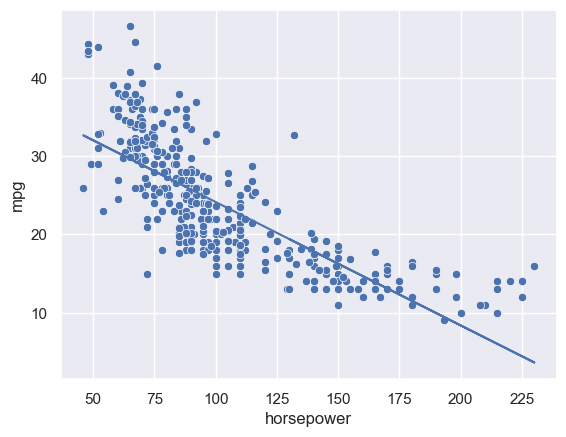

In [52]:
# Let's plot our predicted regression

df = pd.concat([auto_df['horsepower'], auto_df['mpg']], axis=1)
ax = sns.scatterplot(x='horsepower', y='mpg', data=df)
ax.plot(auto_df['horsepower'], y_pred);

#### **(c)** Use the plot() function to produce diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit.

In [55]:
# Functions to emulate R's lm().plot() functionality
# Providing powerful residual plots for simple AND multivariate
# linear regresssion
# - bring your own predictions
# - underlying stats available as pandas dataframe
# - visualise linearity and outliers in multiple dimensions


def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');


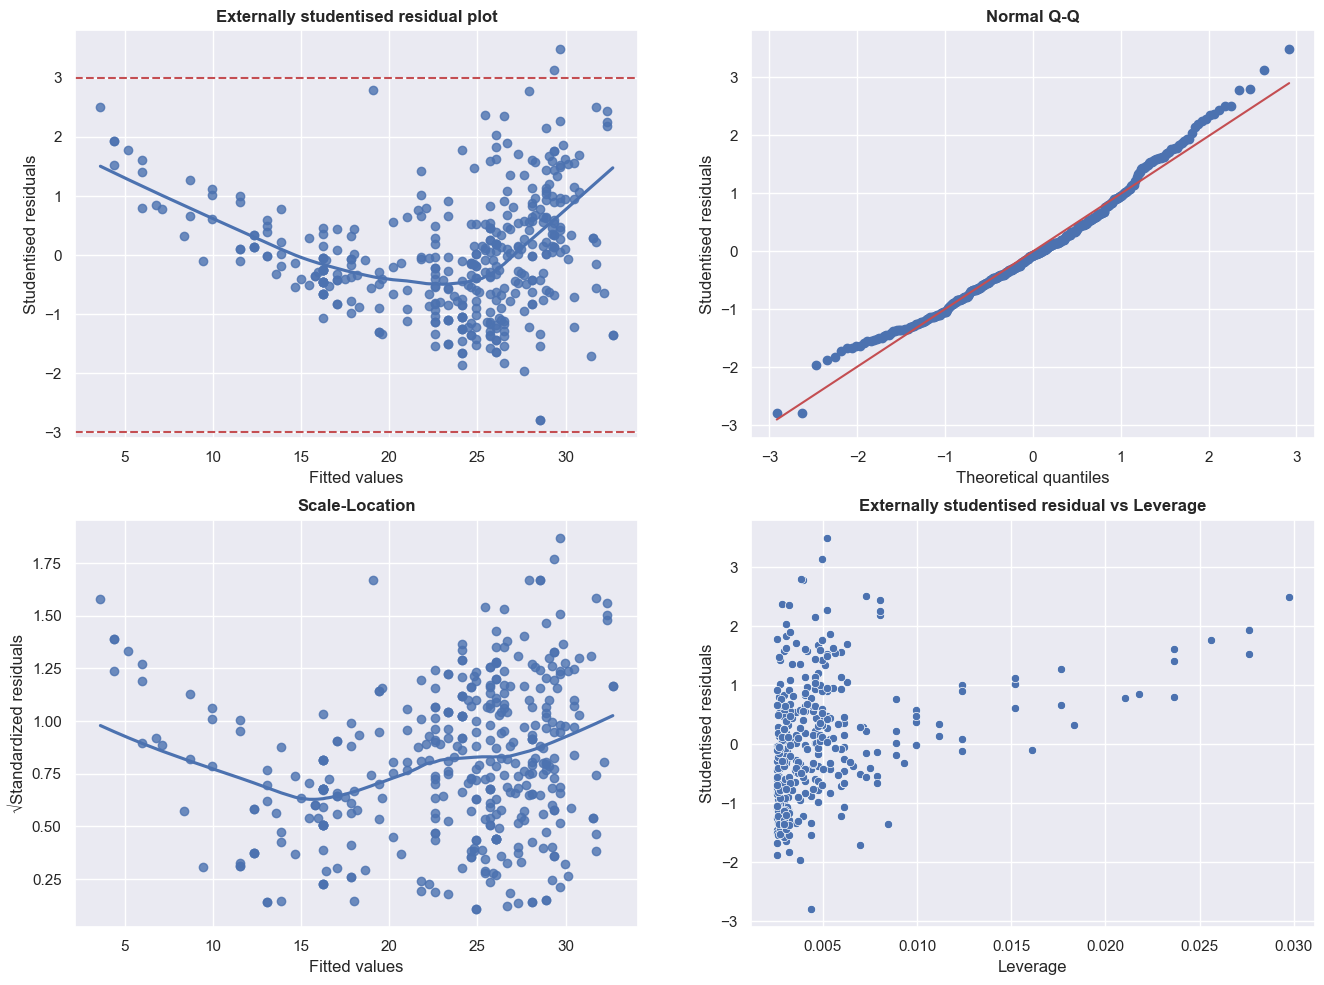

In [54]:
X = pd.concat([auto_df['horsepower']], axis=1)
# Create the Design Matrix by adding constant bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(X.shape[0])})
X = np.array(pd.concat([intercept_const, X], axis=1))

y = auto_df['mpg']

lm_plot(lm_stats(X, y, y_pred))

The above residual plot grid shows the relationship between the horsepower predictor and the mpg response. There are several things to note:

- **Non-linearity of the data:** The top-left residual plot exhibits a discernable pattern, in this case u-shaped, that suggests our linear model is not providing a optimal fit to our data - the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.
- **Heteroscedasticity – Non-constant variance of error terms** The top-left residual plot exhibits a conical shape. This suggests that there is some heteroscedasticity in our predictor. The standardised plot (bottom-left) also exhibits this characteristic suggesting that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by *weighted least squares*.
- **Outliers and leverage:** the bottom-right residual vs leverage plot suggests that there are several potential outliers (points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.
- The top-right plot shows that our studentised residuals have a slightly non-normal distribution (TODO: ellaborate)



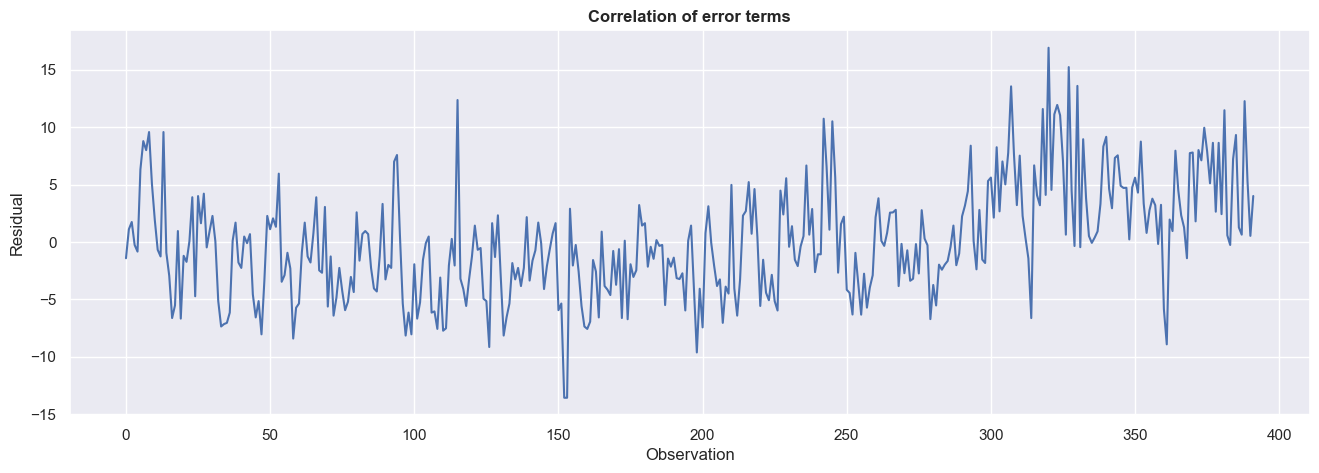

In [56]:
def lm_residual_corr_plot(lm_stats_df):
    r = lm_stats_df['residual']
    # Residuals correlation
    plt.figure(1, figsize=(16, 5))
    ax = sns.lineplot(x=list(range(r.shape[0])), y=r)
    plt.xlabel('Observation')
    plt.ylabel('Residual')
    plt.title('Correlation of error terms', fontweight='bold');  

lm_residual_corr_plot(lm_stats(X, y, y_pred))

- **Correlation of error terms:** The Correlation of Error Terms plot shows errors against ordered observations in our dataset. We see a slight increase in error above the 300th observation suggesting some correlation effect. This could mean that our estimated standard errors underestimate the true standard errors. Our confidence and prediction intervals may be narrower than they should be.

### 9. This question involves the use of multiple linear regression on the Auto data set.

#### **(a)** Produce a scatterplot matrix which includes all of the variables in the data set.

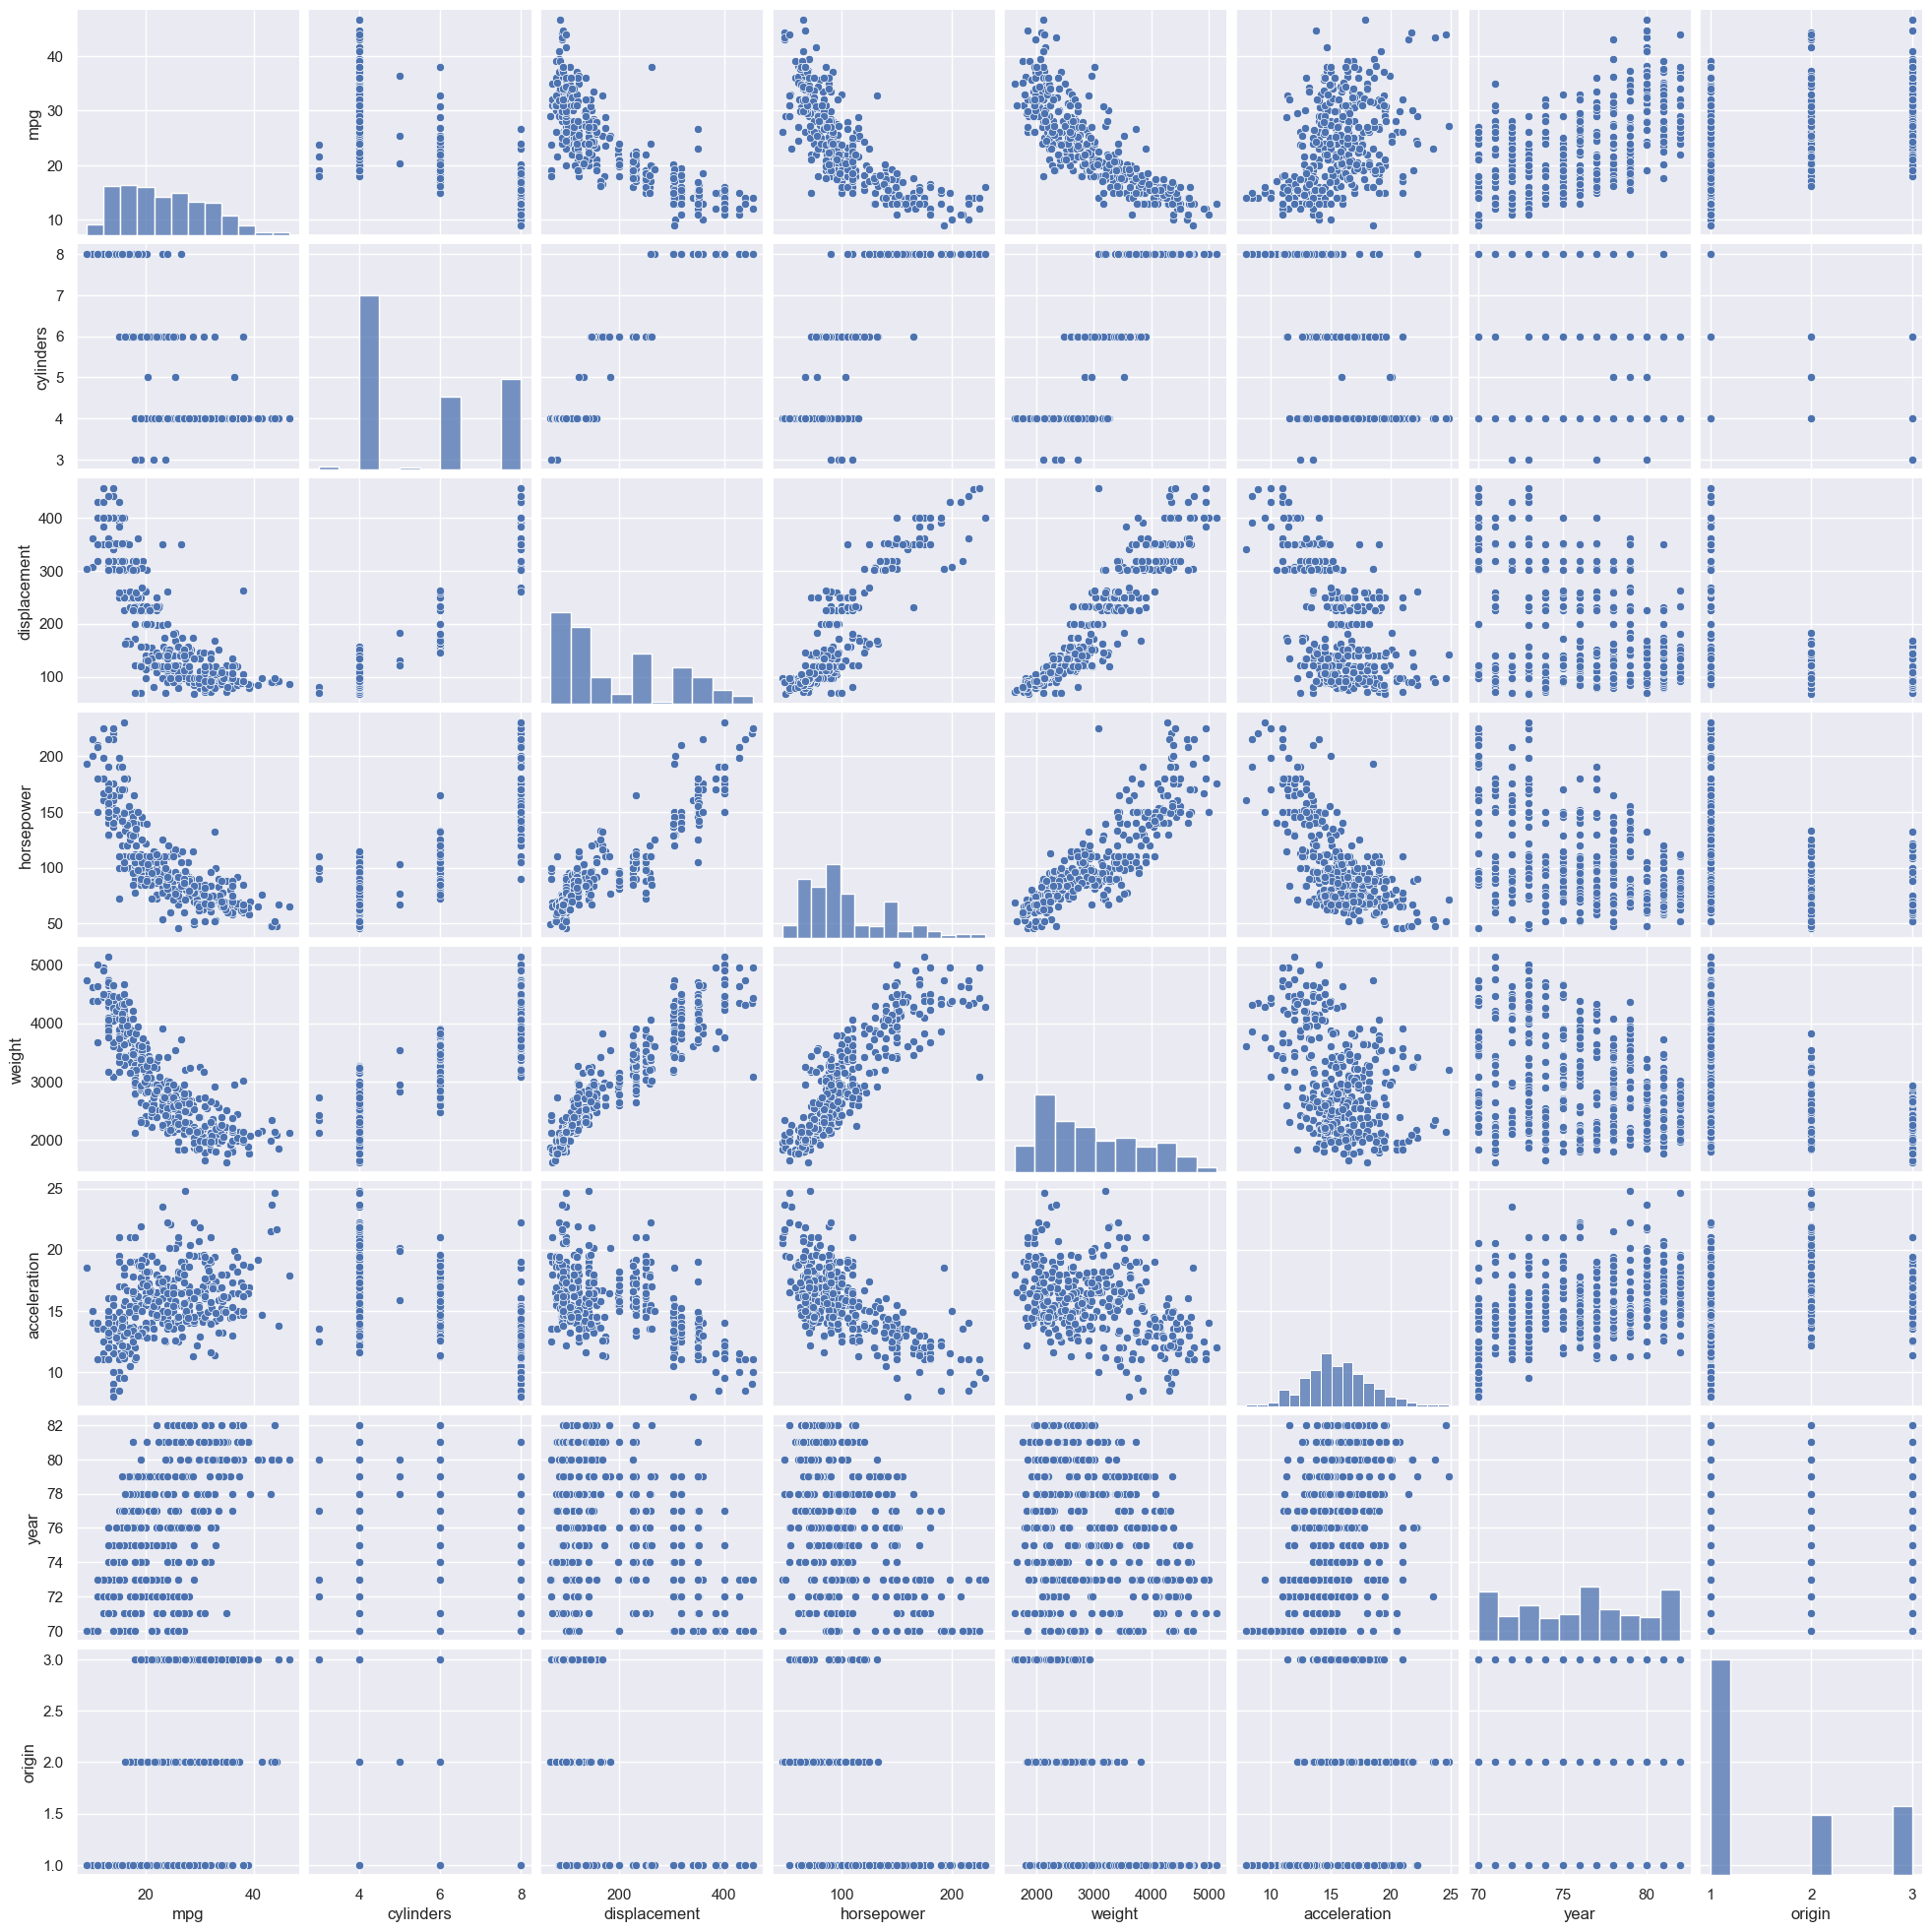

In [57]:
sns.pairplot(auto_df);

#### **(b)** Compute the matrix of correlations between the variables using the function cor(). You will need to exclude the name variable, which is qualitative.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'mpg'),
  Text(0, 1.5, 'cylinders'),
  Text(0, 2.5, 'displacement'),
  Text(0, 3.5, 'horsepower'),
  Text(0, 4.5, 'weight'),
  Text(0, 5.5, 'acceleration'),
  Text(0, 6.5, 'year'),
  Text(0, 7.5, 'origin')])

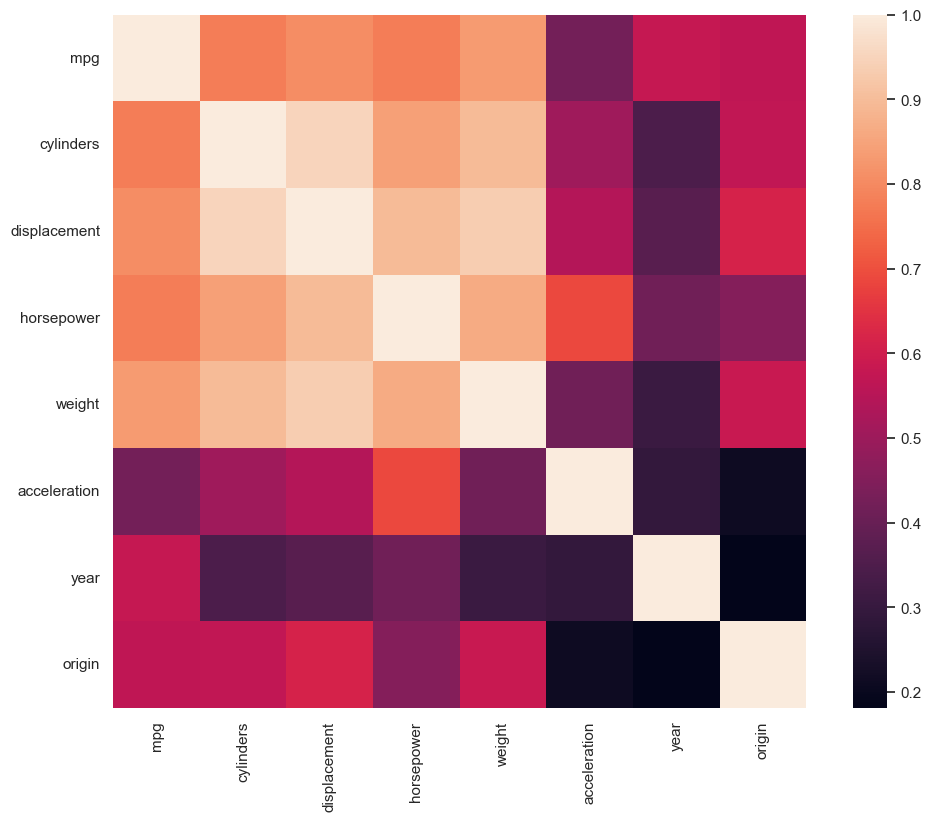

In [60]:
corr_matrix = auto_df.corr(numeric_only=True).abs()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

#### (c) Perform a multiple linear regression with mpg as the response and all other variables except name as the predictors. Use the summary() function to print the results. Comment on the output. For instance:

1. Is there a relationship between the predictors and the response?
2. Which predictors appear to have a statistically significant relationship to the response?
3. What does the coefficient for the year variable suggest?

In [ ]:
f = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

#model = smf.ols(y, X).fit()
model = smf.ols(f, data=auto_df).fit()
print(model.summary())


'''
Formula string + data $\rightarrow$ Use the lowercase function (e.g., smf.ols()).
y and X matrices -> Use the uppercase class (e.g., sm.OLS()).

C -> identifies categorical variables and creates dummy variables
'''

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          1.79e-139
Time:                        20:01:54   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.9546      4.677     -3.

In [ ]:
#core purpose is to translate R-style formula strings (like 'mpg ~ cylinders + displacement + ...') into the numerical matricesthat the underlying statistical algorithms require
help(patsy)

Help on package patsy:

NAME
    patsy

DESCRIPTION
    patsy is a Python package for describing statistical models and building
    design matrices. It is closely inspired by the 'formula' mini-language used in
    R and S.

PACKAGE CONTENTS
    build
    builtins
    categorical
    compat
    compat_ordereddict
    constraint
    contrasts
    desc
    design_info
    eval
    highlevel
    infix_parser
    mgcv_cubic_splines
    missing
    origin
    parse_formula
    redundancy
    splines
    state
    test_build
    test_highlevel
    test_regressions
    test_splines_bs_data
    test_splines_crs_data
    test_state
    tokens
    user_util
    util
    version

CLASSES
    builtins.Exception(builtins.BaseException)
        PatsyError
    builtins.object
        patsy.constraint.LinearConstraint
        patsy.contrasts.ContrastMatrix
        patsy.contrasts.Diff
        patsy.contrasts.Helmert
        patsy.contrasts.Poly
        patsy.contrasts.Sum
        patsy.contrasts.Trea

In [67]:
help(smf)

Help on module statsmodels.formula.api in statsmodels.formula:

NAME
    statsmodels.formula.api

FUNCTIONS
    conditional_logit = from_formula(formula, data, subset=None, drop_cols=None, *args, **kwargs) class method of statsmodels.discrete.conditional_models.ConditionalLogit
        Create a Model from a formula and dataframe.
        
        Parameters
        ----------
        formula : str or generic Formula object
            The formula specifying the model.
        data : array_like
            The data for the model. See Notes.
        subset : array_like
            An array-like object of booleans, integers, or index values that
            indicate the subset of df to use in the model. Assumes df is a
            `pandas.DataFrame`.
        drop_cols : array_like
            Columns to drop from the design matrix.  Cannot be used to
            drop terms involving categoricals.
        *args
            Additional positional argument that are passed to the model.
      

In [68]:
# The following predictors have P-values < 0.05 which suggests we can reject 
# the null hypothesis that they have no relationship with the response:
model.pvalues[model.pvalues < 0.05].sort_values()

year              2.332943e-40
weight            6.375633e-22
C(origin)[T.3]    3.933208e-07
C(origin)[T.2]    4.720373e-06
Intercept         1.445124e-04
displacement      1.862685e-03
dtype: float64

In [86]:
#Here is what the original code was trying to do (upper case OLS) and works with code below
import patsy
import statsmodels.api as sm # New import!
# import statsmodels.formula.api as smf # Still needed if using C(origin) or other formula features

# Your existing patsy lines
f = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

# Use sm.OLS (from statsmodels.api)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          1.79e-139
Time:                        20:23:59   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.9546      4.677     -3.

The coefficient for the `year` variable suggests that there is a positive relationship between `year` and `mpg` – the response variable increases as year increases. Specifically, this suggessts that cars manufactured more recently tend to be more fuel efficient and that all else being equal efficiency increases by 0.75 mpg/year. 


#### (d) Use the plot() function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?

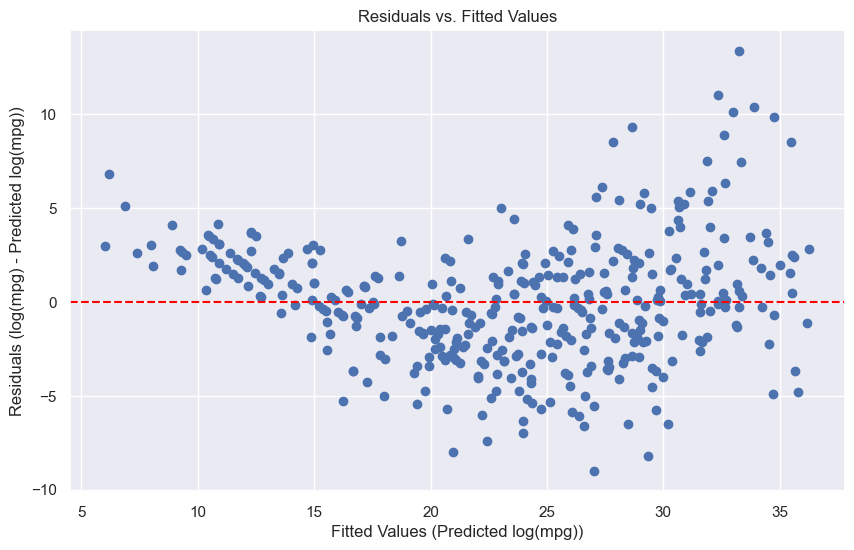

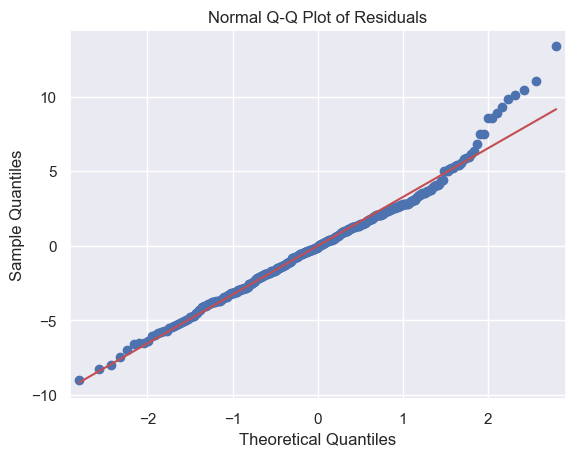

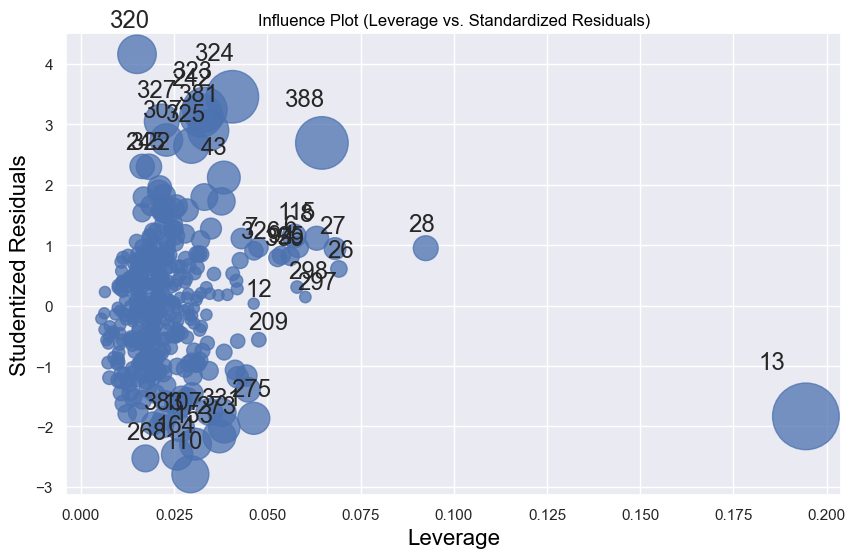

In [87]:
# Make predictions
y_pred = np.array(model.predict(X))

# Analyse residuals
#lm_plot(lm_stats(X, y, y_pred))

# Plot 1: Residuals vs. Fitted Values
# The .resid property holds the residuals (y - y_pred)
# The .fittedvalues property holds the predictions (y_pred)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model.fittedvalues, model.resid)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Residuals vs. Fitted Values')
ax.set_xlabel('Fitted Values (Predicted log(mpg))')
ax.set_ylabel('Residuals (log(mpg) - Predicted log(mpg))')
plt.show()

# Plot 2: Normal Probability (Q-Q) Plot
# This plot checks if the residuals are normally distributed
fig = sm.qqplot(model.resid, line='s') # 's' stands for standardize
plt.title('Normal Q-Q Plot of Residuals')
plt.show()


# Plot 3: Influence Plot (Standardized Residuals vs. Leverage)
fig, ax = plt.subplots(figsize=(10, 6))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.title("Influence Plot (Leverage vs. Standardized Residuals)")
plt.show()

- **Linearity:** The u-shaped pattern in the top-left residual plot suggests that there a non-linear relationship that our model is unable to account for. The bottom left Scale-Location plot suggests that a square-root transform reduces the non-linearity of this relationship allowing our model to achieve an improved fit.
- **Heteroscedasticity:** A conical pattern is apparent in the top-left plot suggesting that variance of residuals increases with response. The bottom left plot suggests that a square-root transform helps to mitigate this effect.
- **Outliers:** The top-left plot suggests that there are five potential outliers towards the high end of our predicted responses. The bottom-right plot suggests that these outliers have low leverage, and so probably don't have a overly dispraportionate effect on our model.
- **Leverage:** The bottom right plot reveals one point with particularly high leverage, although with a value around -1.2 this point isn't an outlier in terms of studentised residuals.
- **Normality:** The top-right plot shows a normal distribution except for high value residuals. This suggests that the model under-estimates `mpg` for a larger number of observations than we might expect assuming a normal distribution.



#### (e) Use the * and : symbols to fit linear regression models with interaction effects. Do any interactions appear to be statistically significant?

In [73]:
# Let's fit a model with all possible interaction effects

f = 'np.log1p(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin) \
    + cylinders*displacement \
    + cylinders*horsepower \
    + cylinders*weight \
    + cylinders*acceleration \
    + cylinders*year \
    + displacement*horsepower \
    + displacement*weight \
    + displacement*acceleration \
    + displacement*year \
    + horsepower*weight \
    + horsepower*acceleration \
    + horsepower*year \
    + weight*weight \
    + weight*acceleration \
    + weight*year \
    + acceleration*year \
    '

y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log1p(mpg)   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     152.3
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          2.31e-172
Time:                        20:16:22   Log-Likelihood:                 346.65
No. Observations:                 392   AIC:                            -645.3
Df Residuals:                     368   BIC:                            -550.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [74]:
# If we take p < 0.05 as our significance threshold
# which features appear as significant in this model?
model.pvalues[model.pvalues < 0.05].sort_values()

cylinders:displacement    0.009575
acceleration              0.009944
acceleration:year         0.011091
displacement:year         0.017965
Intercept                 0.048352
dtype: float64

Only the above features seem to be statistically significant in this model.

Notice the warning (2) that suggests the might be multicollinearity in this model. We can observe in the correlation plot above that there is strong collinearity between mpg, cylinders, displacement, horespower, and weight. This means further investigation is required to discern which, if any, of these features have a *causal* relationship with our response `mpg`.  

#### (f) Try a few different transformations of the variables, such as log(X), √X, X2. Comment on your findings.

Let's start by taking log of the response variable only.

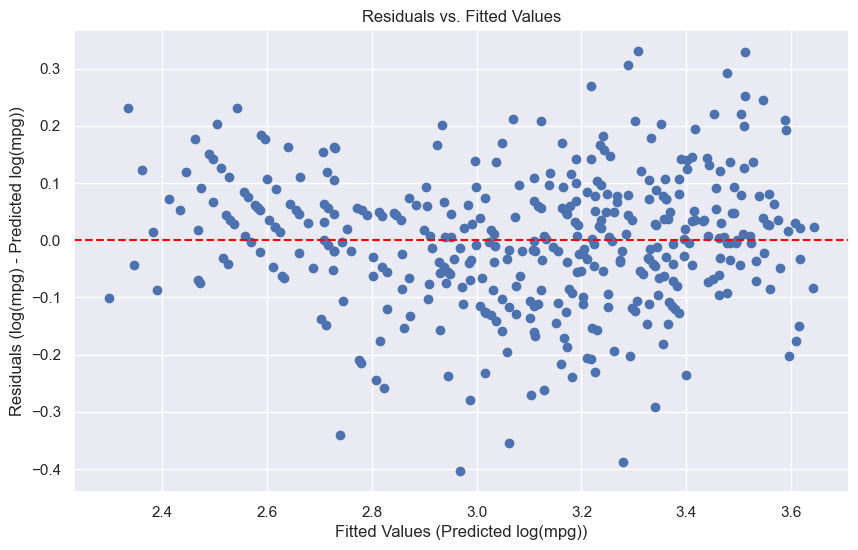

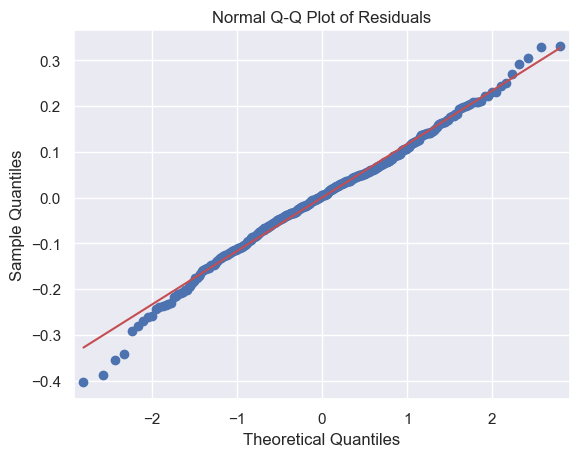

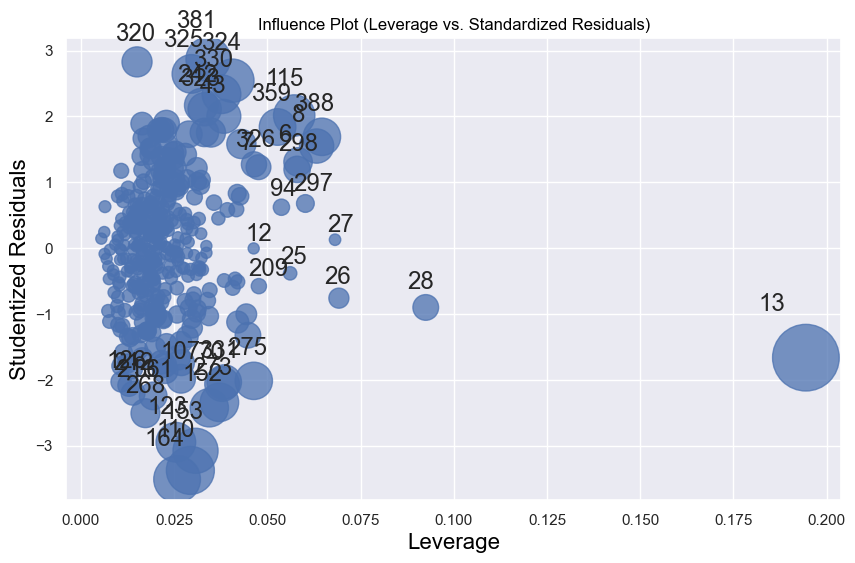

In [85]:
# Note: taking log of response variable to normalise distribution
f = 'np.log(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()

# Make predictions
y_pred = np.array(model.predict(X))

# Analyse residuals
#lm_plot(lm_stats(X, y, y_pred))

# Plot 1: Residuals vs. Fitted Values
# The .resid property holds the residuals (y - y_pred)
# The .fittedvalues property holds the predictions (y_pred)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model.fittedvalues, model.resid)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Residuals vs. Fitted Values')
ax.set_xlabel('Fitted Values (Predicted log(mpg))')
ax.set_ylabel('Residuals (log(mpg) - Predicted log(mpg))')
plt.show()

# Plot 2: Normal Probability (Q-Q) Plot
# This plot checks if the residuals are normally distributed
fig = sm.qqplot(model.resid, line='s') # 's' stands for standardize
plt.title('Normal Q-Q Plot of Residuals')
plt.show()


# Plot 3: Influence Plot (Standardized Residuals vs. Leverage)
fig, ax = plt.subplots(figsize=(10, 6))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.title("Influence Plot (Leverage vs. Standardized Residuals)")
plt.show()

**Comment:** Taking the log of the response variable dramatically improves aspects of our diagnostic plots.

- there is less pattern in the left-hand residual plots suggesting the log transform of `mpg` as decreased the non-linearity of its relationship to features and so improved our models ability to fit the date.
- there is a reduction in the conic shape of the bottom left plot suggesting a reduction in homoscedasticity
- the top-right plot suggests the model is now inclined to overstimate instead of underestimate
- there are no-longer any outliers exceeding a studentised residual value of three. there are now two outliers <-3


**Question:** What if we take logs of all our predictor variables also?

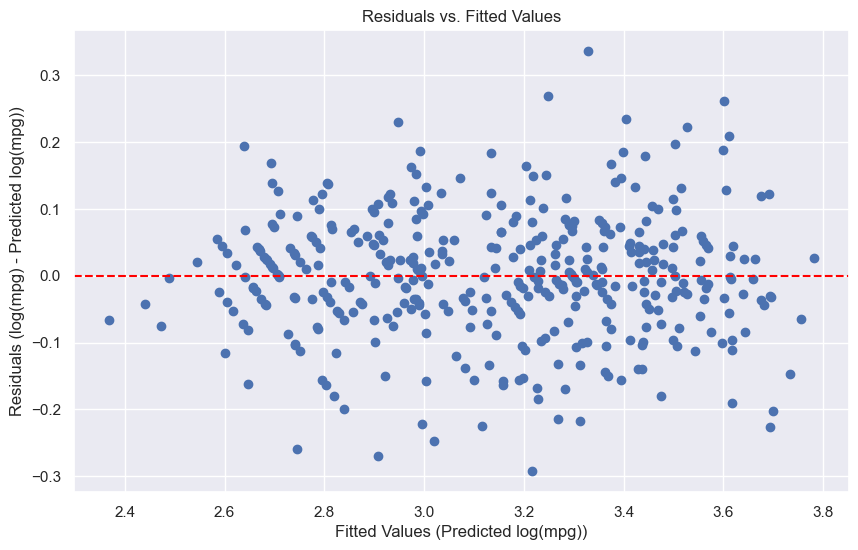

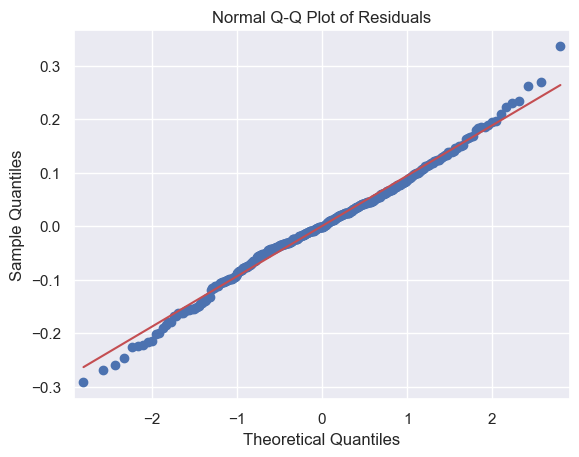

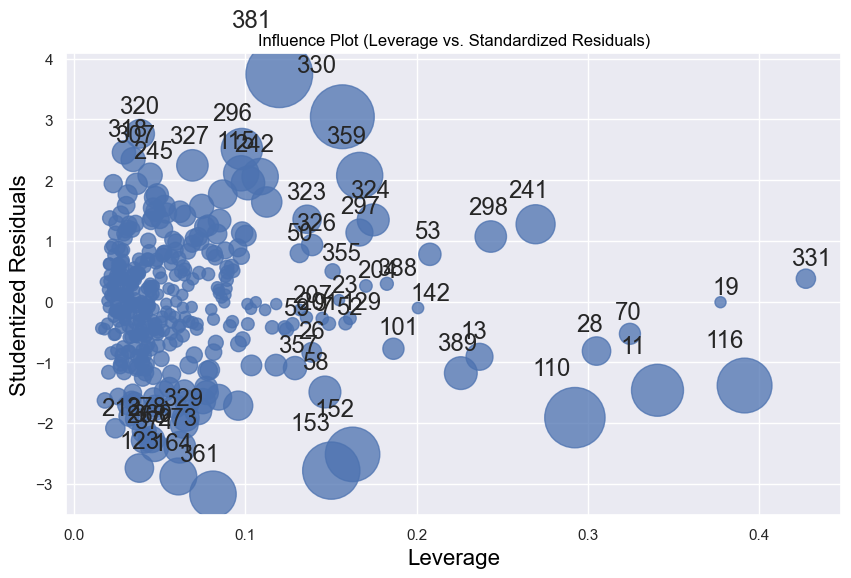

In [89]:
f = 'np.log1p(mpg) \
    ~ np.log1p(cylinders) \
    + np.log1p(displacement) \
    + np.log1p(horsepower) \
    + np.log1p(weight) \
    + np.log1p(acceleration) \
    + np.log1p(year) \
    + C(origin) \
    + np.log1p(cylinders*displacement) \
    + np.log1p(cylinders*horsepower) \
    + np.log1p(cylinders*weight) \
    + np.log1p(cylinders*acceleration) \
    + np.log1p(cylinders*year) \
    + np.log1p(displacement*horsepower) \
    + np.log1p(displacement*weight) \
    + np.log1p(displacement*acceleration) \
    + np.log1p(displacement*year) \
    + np.log1p(horsepower*weight) \
    + np.log1p(horsepower*acceleration) \
    + np.log1p(horsepower*year) \
    + np.log1p(weight*weight) \
    + np.log1p(weight*acceleration) \
    + np.log1p(weight*year) \
    + np.log1p(acceleration*year) \
    '

y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')
model = sm.OLS(y, X).fit()
#print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))

# Analyse residuals
#lm_plot(lm_stats(X, y, y_pred))

# Plot 1: Residuals vs. Fitted Values
# The .resid property holds the residuals (y - y_pred)
# The .fittedvalues property holds the predictions (y_pred)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model.fittedvalues, model.resid)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Residuals vs. Fitted Values')
ax.set_xlabel('Fitted Values (Predicted log(mpg))')
ax.set_ylabel('Residuals (log(mpg) - Predicted log(mpg))')
plt.show()

# Plot 2: Normal Probability (Q-Q) Plot
# This plot checks if the residuals are normally distributed
fig = sm.qqplot(model.resid, line='s') # 's' stands for standardize
plt.title('Normal Q-Q Plot of Residuals')
plt.show()


# Plot 3: Influence Plot (Standardized Residuals vs. Leverage)
fig, ax = plt.subplots(figsize=(10, 6))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.title("Influence Plot (Leverage vs. Standardized Residuals)")
plt.show()



In [90]:
# If we take p < 0.05 as our significance threshold
# which features appear as significant in this model?
model.pvalues[model.pvalues < 0.05].sort_values()

np.log1p(cylinders * displacement)     5.450938e-07
np.log1p(year)                         3.554276e-06
Intercept                              4.103286e-06
np.log1p(horsepower * acceleration)    4.088496e-04
np.log1p(cylinders * acceleration)     5.328883e-03
np.log1p(horsepower * weight)          1.089279e-02
np.log1p(horsepower * year)            2.345207e-02
np.log1p(displacement)                 3.208041e-02
np.log1p(cylinders * horsepower)       4.141974e-02
dtype: float64

**Comment:** Comparing the above diagnostics grid with the preceding grid suggests that taking log of predictors has further reduced the non-linearities in our dataset. 

The number of observations that appear as outliers has reduced from two to one. Heteroscedasticity has also been reduced. The distribtuion of studentised residuals is more normal.

There is notably increased variance in the leverage of our observations.

**Question:** what if we only use the features from this model with p-values < 0.05?


                            OLS Regression Results                            
Dep. Variable:            np.log(mpg)   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     394.3
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          1.11e-179
Time:                        20:26:10   Log-Likelihood:                 302.85
No. Observations:                 392   AIC:                            -587.7
Df Residuals:                     383   BIC:                            -552.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

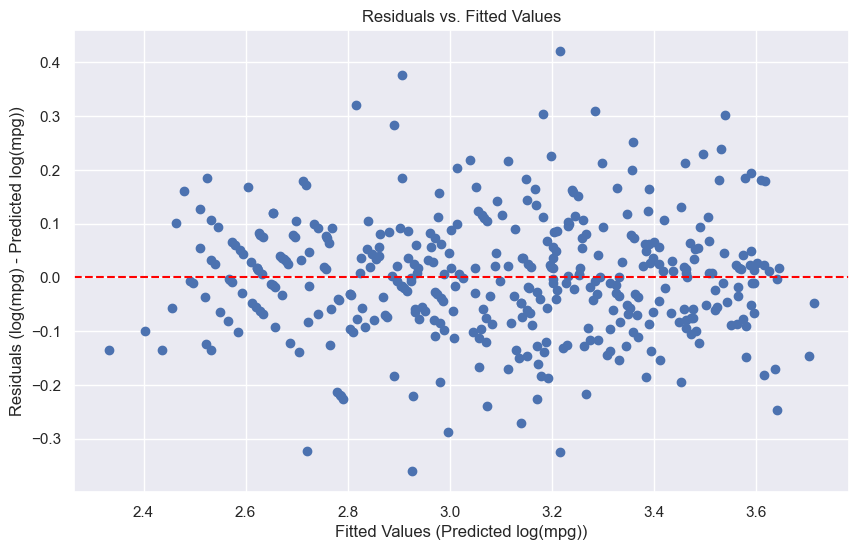

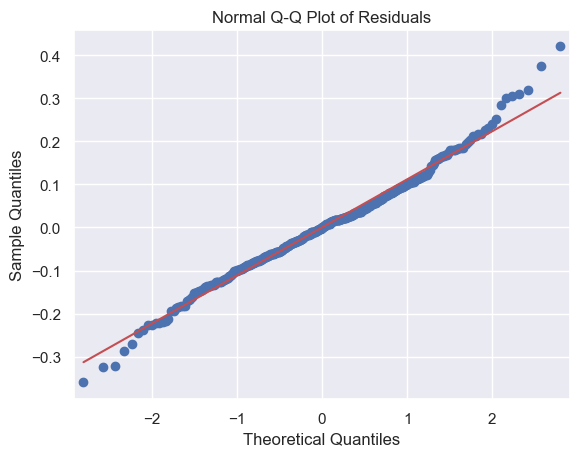

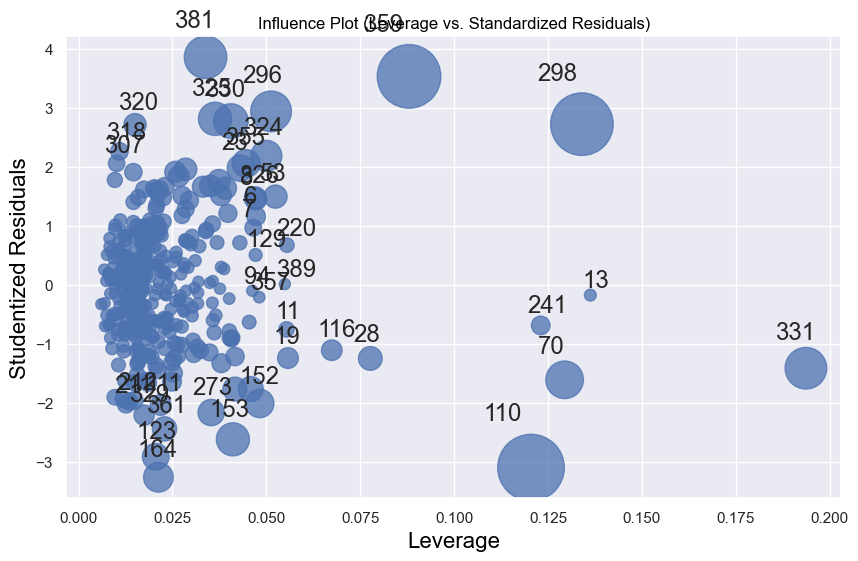

In [92]:
# Let's use just the most significant features from the set of all log features
significant_features = model.pvalues[model.pvalues < 0.05].drop('Intercept').index
f = 'np.log(mpg) ~ ' + ' + '.join(list(significant_features))

y, X = patsy.dmatrices(f, auto_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()

# Make predictions
y_pred = np.array(model.predict(X))

# If we take p < 0.05 as our significance threshold
# which features appear as significant in this model?
print(model.summary())

# Analyse residuals
#lm_plot(lm_stats(X, y, y_pred))

# Plot 1: Residuals vs. Fitted Values
# The .resid property holds the residuals (y - y_pred)
# The .fittedvalues property holds the predictions (y_pred)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model.fittedvalues, model.resid)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Residuals vs. Fitted Values')
ax.set_xlabel('Fitted Values (Predicted log(mpg))')
ax.set_ylabel('Residuals (log(mpg) - Predicted log(mpg))')
plt.show()

# Plot 2: Normal Probability (Q-Q) Plot
# This plot checks if the residuals are normally distributed
fig = sm.qqplot(model.resid, line='s') # 's' stands for standardize
plt.title('Normal Q-Q Plot of Residuals')
plt.show()


# Plot 3: Influence Plot (Standardized Residuals vs. Leverage)
fig, ax = plt.subplots(figsize=(10, 6))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.title("Influence Plot (Leverage vs. Standardized Residuals)")
plt.show()

The top-left plot suggests that our model is now fitting the data with even less loss. There is no notable heteroscedasticity, and the distribution of the residuals appears normal.

The variance in leverage of observations is reduced and there are three potential outliers.

In the top-left residual plot there is a repeating linear pattern for `Fitted values < 2.8`. This pattern is not visible in the plot below.

**Question:** Would the taking square root of features provide improved results?

I tried the above, taking square root of log(features)


### 10. This question should be answered using the Carseats data set.

#### (a) Fit a multiple regression model to predict Sales using Price, Urban, and US.

In [97]:
# Load data
carseats = pd.read_csv('./data/Carseats.csv').drop('Unnamed: 0', axis=1)

# No missing values found

# Pre-processing
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education'],
             'qual': ['ShelveLoc', 'Urban', 'US']}
# Use floats for all quantitive values
quants = carseats[datatypes['quant']].astype(np.float64)
carseats_df = pd.concat([quants, carseats[datatypes['qual']]], axis=1)

carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc,Urban,US
0,9.50,138.0,73.0,11.0,276.0,120.0,42.0,17.0,Bad,Yes,Yes
1,11.22,111.0,48.0,16.0,260.0,83.0,65.0,10.0,Good,Yes,Yes
2,10.06,113.0,35.0,10.0,269.0,80.0,59.0,12.0,Medium,Yes,Yes
3,7.40,117.0,100.0,4.0,466.0,97.0,55.0,14.0,Medium,Yes,Yes
4,4.15,141.0,64.0,3.0,340.0,128.0,38.0,13.0,Bad,Yes,No


In [98]:
# Feature engineering
f = 'Sales ~ Price + C(Urban) + C(US)'
y, X = patsy.dmatrices(f, carseats_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           2.39e-23
Time:                        20:28:19   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.0435      0.651     

### (b) Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

Our model suggests that:

- Sales decrease with increase in Price. For each unit increase in Price, Sales decrease by `0.0545 * 1000 = 54.5 dollars` on average.
- There seems to be a statistically significant relationship between Sales and whether the store is in the U.S. or not. We expect carseats sold in the US to achieve a salprice 1,200 dollars higher on average.
- There does not seem to be significant relationship between Sales and wheter the store is in an urban or rural relationship

### (c) Write out the model in equation form, being careful to handle the qualitative variables properly.

$\hat{y} = 13.0435 + (-0.0219 \times Urban) + (1.2006 \times US) + (-0.0545 \times Price) $

Where Urban and US are encoded as dummy variables:

- Urban: Yes => 1
- Urban:No   => 0
- US: Yes    => 1
- US: No     => 0

### (d) For which of the predictors can you reject the null hypothesis H0 :βj =0?

US, Price

### (e) On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

In [99]:
# Feature engineering
f = 'Sales ~ Price + C(US)'
y, X = patsy.dmatrices(f, carseats_df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           2.66e-24
Time:                        20:30:04   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0308      0.631     20.652   

### (f) How well do the models in (a) and (e) fit the data?

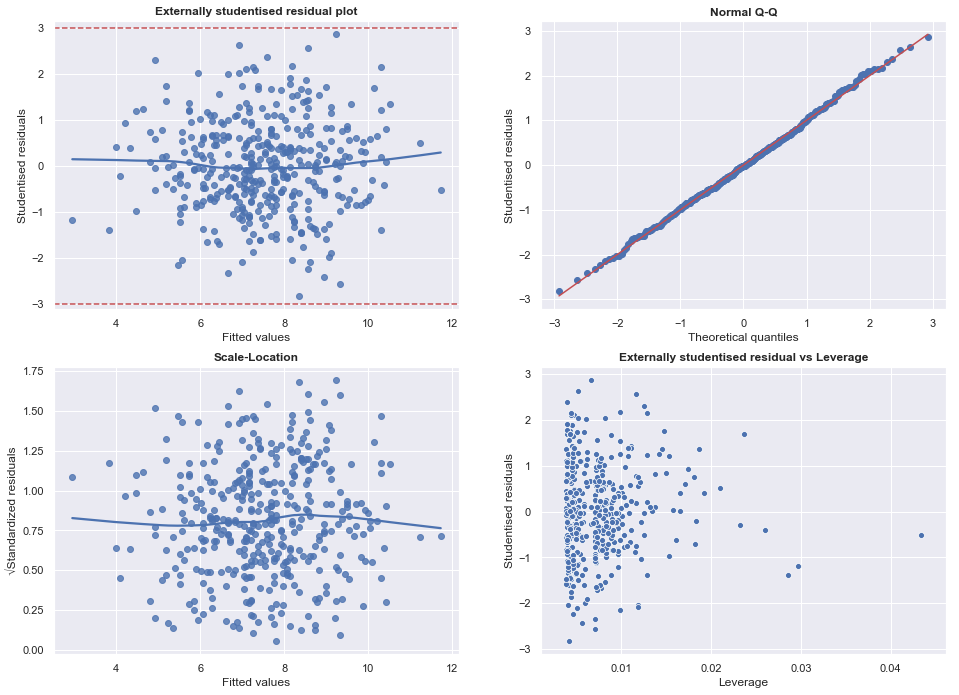

In [ ]:
# Analyse residuals - this code doesn't actually work
lm_plot(lm_stats(X, y, y_pred))

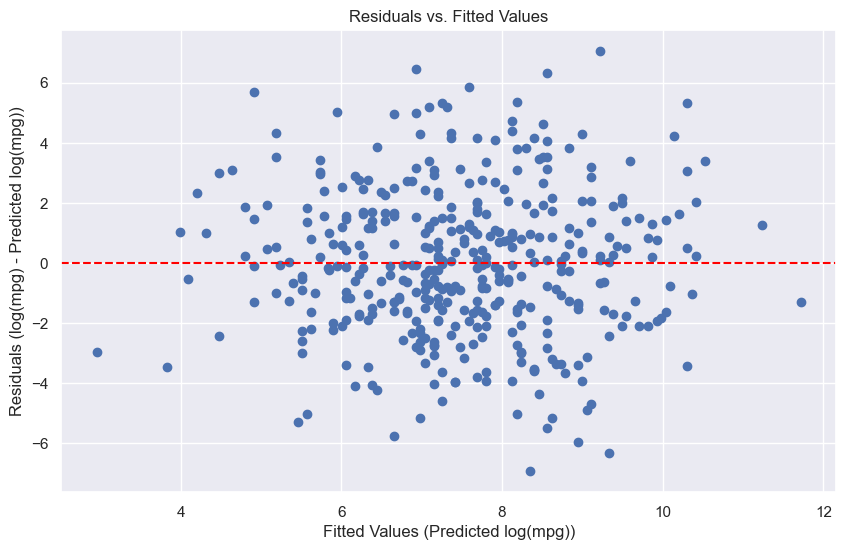

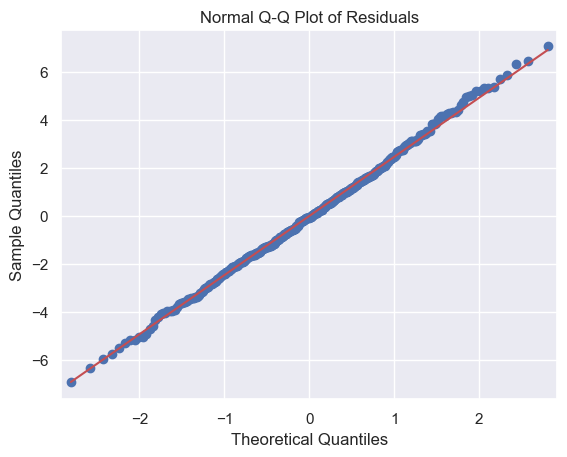

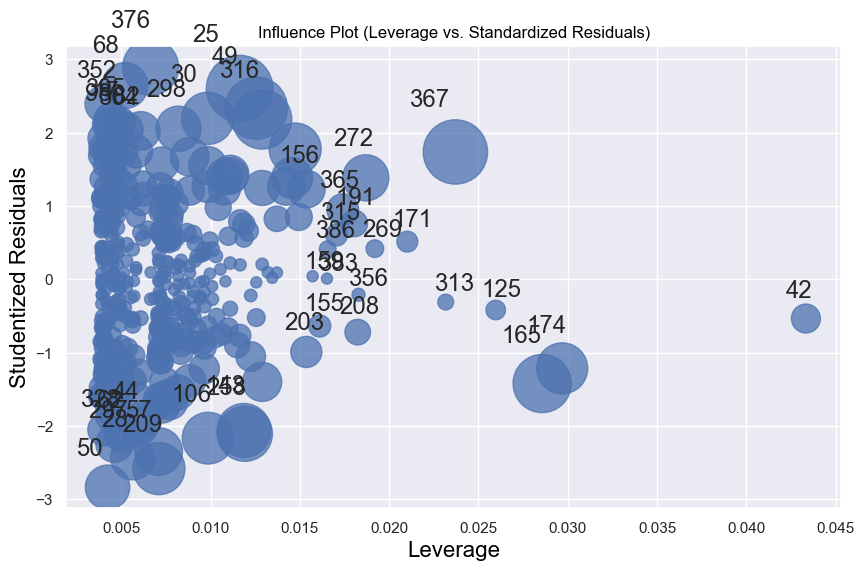

In [100]:
# Plot 1: Residuals vs. Fitted Values
# The .resid property holds the residuals (y - y_pred)
# The .fittedvalues property holds the predictions (y_pred)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model.fittedvalues, model.resid)
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Residuals vs. Fitted Values')
ax.set_xlabel('Fitted Values (Predicted log(mpg))')
ax.set_ylabel('Residuals (log(mpg) - Predicted log(mpg))')
plt.show()

# Plot 2: Normal Probability (Q-Q) Plot
# This plot checks if the residuals are normally distributed
fig = sm.qqplot(model.resid, line='s') # 's' stands for standardize
plt.title('Normal Q-Q Plot of Residuals')
plt.show()


# Plot 3: Influence Plot (Standardized Residuals vs. Leverage)
fig, ax = plt.subplots(figsize=(10, 6))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.title("Influence Plot (Leverage vs. Standardized Residuals)")
plt.show()

**Comment:** The diagnostic plots above illustrate the fit of our model. The top-left plot shows only subtle discernible pattern suggesting our linear model has achieved a reasonable fit to the data. The distribution of residuals appears normal and there is no heteroscedasticity. 

### (g) Using the model from (e), obtain 95% confidence intervals for the coefficient(s).


In [102]:
# Extract 95% confidence intervals
conf_inter_95 = model.conf_int(alpha=0.05)
conf_inter_95.rename(index=str, columns={0: "LCL", 1: "UCL",})

,LCL,UCL
Intercept,11.79032,14.271265
C(US)[T.Yes],0.69152,1.707766
Price,-0.06476,-0.044195


### (h) Is there evidence of outliers or high leverage observations in the model from (e)?

No observations exceed the studentised residual thresholds for outliers of +/-3, although a couple come close.

There is one observation that stands out as particularly high leverage in the bottom-right plot above, but this observation is not an outlier.

## 11. In this problem we will investigate the t-statistic for the null hypothesis H0 : β = 0 in simple linear regression without an intercept. To begin, we generate a predictor x and a response y as follows.

<Axes: >

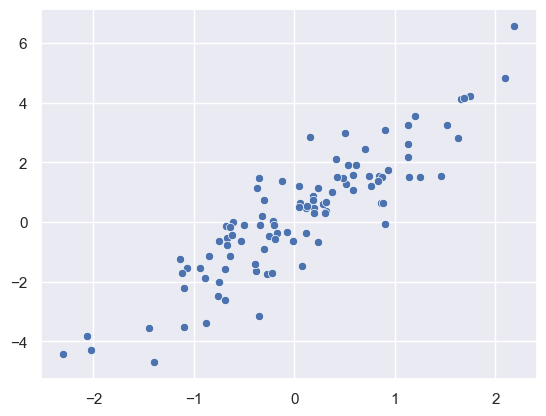

In [103]:
np.random.seed(1)
x  = np.random.normal(size=100)
y  = 2*x + np.random.normal(size=100)
df = pd.DataFrame({'x': x, 'y': y}) 
sns.scatterplot(x=x, y=y, color='b')

#### (a) Perform a simple linear regression of y onto x, without an intercept. Report the coefficient estimate βˆ, the standard error of this coefficient estimate, and the t-statistic and p-value associated with the null hypothesis H0 : β = 0. Comment on these results. (You can perform regression without an intercept using the command lm(y∼x+0).)

In [104]:
# Linear regression without intercept
f = 'y ~ x + 0'
y, X = patsy.dmatrices(f, df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary(alpha=0.05))


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Sun, 14 Dec 2025   Prob (F-statistic):                    3.46e-36
Time:                        20:34:09   Log-Likelihood:                         -135.67
No. Observations:                 100   AIC:                                      273.3
Df Residuals:                      99   BIC:                                      275.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Our model estimates the coefficient of x as 2.1067 which is a slight overestimate of the known true value of 2.0, however the 95% confidence bounds do include the true value of x. 

Our model suggests that there is a significant relationship between x and y.

#### (b) Now perform a simple linear regression of x onto y without an intercept, and report the coefficient estimate, its standard error, and the corresponding t-statistic and p-values associated with the null hypothesis H0 : β = 0. Comment on these results.

In [111]:
# Linear regression without intercept
f = 'x ~ y+0'
y, X = patsy.dmatrices(f, df, return_type='dataframe')

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary(alpha=0.05))

                                 OLS Regression Results                                
Dep. Variable:                      x   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Sun, 14 Dec 2025   Prob (F-statistic):                    3.46e-36
Time:                        20:38:32   Log-Likelihood:                         -49.891
No. Observations:                 100   AIC:                                      101.8
Df Residuals:                      99   BIC:                                      104.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We know that y increases by 0.5 for every unit increase in x. Our model understimates this coefficient predicting 0.3789.

The standard error is now almost 10x lower at 0.019, the t-statistic is the same, and the p-value still suggests we should reject the null hyptothesis that there is no relationship between y and x.


### (c) What is the relationship between the results obtained in (a) and (b)?

from a)  
$\hat{y} = βx + ε$

rearranging for b)

$\hat{x} = \frac{y - ε}{β}$

we know that $β = 2$

The standard error is lower for b), but because the coeffient is proportionally closer to 0 the t-statistic is unaffected.


(d) see workings

### (e) Using the results from (d), argue that the t-statistic for the re- gression of y onto x is the same as the t-statistic for the regression of x onto y.

In the equation given for t, y and x are associative – switching their order does not effect the result.

### (f) In R, show that when regression is performed with an intercept, the t-statistic for H0 : β1 = 0 is the same for the regression of y onto x as it is for the regression of x onto y.

In [109]:
# Fit model
model_a = smf.ols(formula='y ~ x', data=df).fit()
model_b = smf.ols(formula='x ~ y', data=df).fit()

print(model_a.tvalues)
print(model_b.tvalues)

Intercept     1.564347
x            19.782585
dtype: float64
Intercept    -1.089559
y            19.782585
dtype: float64


## 12. This problem involves simple linear regression without an intercept.

### (a) Recall that the coefficient estimate βˆ for the linear regression of Y onto X without an intercept is given by (3.38). Under what circumstance is the coefficient estimate for the regression of X onto Y the same as the coefficient estimate for the regression of Y onto X?

when 

$\sum_{i=1}^{n} x_i = \sum_{i=1}^{n} y_i$

in which case $\hat{β} = 1$

### (b) Generate an example in R with n = 100 observations in which the coefficient estimate for the regression of X onto Y is different from the coefficient estimate for the regression of Y onto X.

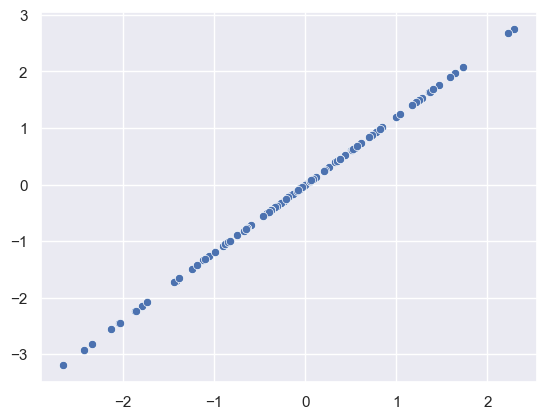

In [112]:
np.random.seed(2)
x = np.random.normal(size=100)
y = 1.2*x
df = pd.DataFrame({'x': x, 'y': y})
sns.scatterplot(x=x, y=y);

In [113]:
model_a = smf.ols(formula='y ~ x', data=df).fit()
model_b = smf.ols(formula='x ~ y', data=df).fit()

print(model_a.params)
print(model_b.params)

Intercept   -2.498002e-16
x            1.200000e+00
dtype: float64
Intercept   -2.775558e-17
y            8.333333e-01
dtype: float64


### (c) Generate an example in R with n = 100 observations in which the coefficient estimate for the regression of X onto Y is the same as the coefficient estimate for the regression of Y onto X.


Intercept   -2.081668e-17
x            1.000000e+00
dtype: float64
Intercept   -2.081668e-17
y            1.000000e+00
dtype: float64


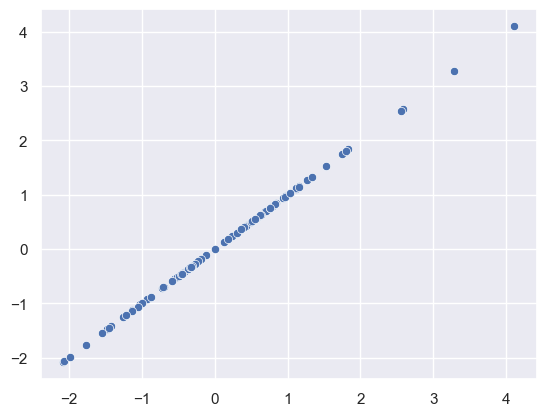

In [114]:
x = np.random.normal(size=100)
y = x
df = pd.DataFrame({'x': x, 'y': y})
sns.scatterplot(x=x, y=y);

model_a = smf.ols(formula='y ~ x', data=df).fit()
model_b = smf.ols(formula='x ~ y', data=df).fit()

print(model_a.params)
print(model_b.params)

## 13. In this exercise you will create some simulated data and will fit simple linear regression models to it. Make sure to use set.seed(1) prior to starting part (a) to ensure consistent results.

### (a) Using the rnorm() function, create a vector, x, containing 100 observations drawn from a N(0,1) distribution. This represents a feature, X.

In [115]:
np.random.seed(1)

mu, sigma = 0, 1
x = np.random.normal(mu, sigma, 100)

### (b) Using the rnorm() function, create a vector, eps, containing 100 observations drawn from a N(0,0.25) distribution i.e. a normal distribution with mean zero and variance 0.25.

In [116]:
mu, sigma = 0, 0.25
eps = np.random.normal(mu, sigma, 100)

### (c) Using x and eps, generate a vector y according to the model

Y =−1+0.5X+ε. (3.39)  

In [117]:
y = -1 + 0.5*x + eps

### What is the length of the vector y? What are the values of β0 and β1 in this linear model? 

This is actually the euclidean length or L2 norm of vector y; how far the date cloud is from the origin

$$\|\mathbf{y}\|_2 = \sqrt{\sum_{i=1}^{n} y_i^2}$$

This number represents the distance of the vector's endpoint from the origin in a 100-dimensional space. calculated using the Pythagorean theorem

β0 = -1  
β1 = 0.5


Concepts:

1. 🔍 Measuring Data MagnitudeThe $\mathbf{L^2}$ Norm ($\|\mathbf{y}\|_2$) provides a single number representing the overall magnitude of the data in your vector.
    * Vector Length: It tells you how "far" the data cloud (represented by the vector $y$ in a high-dimensional space) is from the origin.
    * Scale: In a linear model, the magnitude of the response variable is crucial for understanding the scale of the coefficients and the size of the errors.
2. 🛡️ Foundation of Regression ErrorThe $L^2$ Norm is the mathematical foundation of the most common and standard way to measure the performance of a linear regression model: Ordinary Least Squares (OLS).
    * Residual Sum of Squares (RSS): The most fundamental error metric is the Residual Sum of Squares, which is the sum of the squared residuals ($\mathbf{e}$).$$\text{RSS} = \sum_{i=1}^{n} e_i^2 = \|\mathbf{e}\|_2^2$$This is simply the squared $\mathbf{L^2}$ Norm of the residual vector. Minimizing the RSS is the entire goal of the OLS method.
    
    * Root Mean Squared Error (RMSE): The RMSE, a standard metric for model performance, is derived directly from the RSS and is measured in the original units of $\mathbf{y}$.
3. ⚖️ Regularization (Ridge Regression)In advanced linear regression techniques, the 1$\mathbf{L^2}$ Norm is directly used to penalize complexity in the model.
    * Ridge Regression (L2 Regularization): This technique adds a penalty term to the OLS cost function, which is the squared 3$\mathbf{L^2}$ Norm of the coefficient vector (4$\beta$):5$$\text{Cost} = \text{RSS} + \lambda \sum_{j=1}^{p} \beta_j^2 = \text{RSS} + \lambda \|\mathbf{\beta}\|_2^2$$This penalty ensures that the model coefficients (6$\beta$) are kept small, which helps prevent overfitting.7

4. 📐 Geometry in High DimensionsIn high-dimensional feature spaces, the 8$L^2$ Norm is the standard way to measure the distance between two data points or two vectors.
    * Euclidean Distance: The distance between two vectors 10$\mathbf{a}$ and 11$\mathbf{b}$ is simply the 12$\mathbf{L^2}$ Norm of their difference:13$$\text{Distance}(\mathbf{a}, \mathbf{b}) = \|\mathbf{a} - \mathbf{b}\|_2$$This measure is fundamental to algorithms like $k$-Nearest Neighbors (kNN) and $k$-Means Clustering.

In [ ]:
print('y euclidean length: ' + str(np.linalg.norm(y)))

y length: 10.660986158906173


In [120]:
print(len(y))
print(y.shape)

100
(100,)


### (d) Create a scatterplot displaying the relationship between x and y. Comment on what you observe.

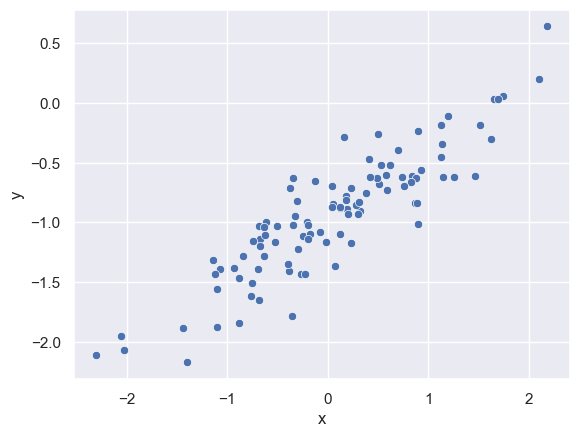

In [121]:
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y');

The above plot suggests a linear relationship between x and y with an intercept of roughly -1 and gradient of 0.5

### (e) Fit a least squares linear model to predict y using x. Comment on the model obtained. How do βˆ0 and βˆ1 compare to β0 and β1?

In [122]:
model = smf.ols(formula='y ~ x', data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     391.4
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           5.39e-36
Time:                        20:53:59   Log-Likelihood:                 4.1908
No. Observations:                 100   AIC:                            -4.382
Df Residuals:                      98   BIC:                            0.8288
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9632      0.023    -40.999      0.0

$\hat{β_0} = -0.9632$  
$\hat{β_1} = 0.5239$

The model estimates parameters close to the true values. The intercept is overestimated and the gradient is overestimated.

### (f) Display the least squares line on the scatterplot obtained in (d). Draw the population regression line on the plot, in a different color. Use the legend() command to create an appropriate legend.

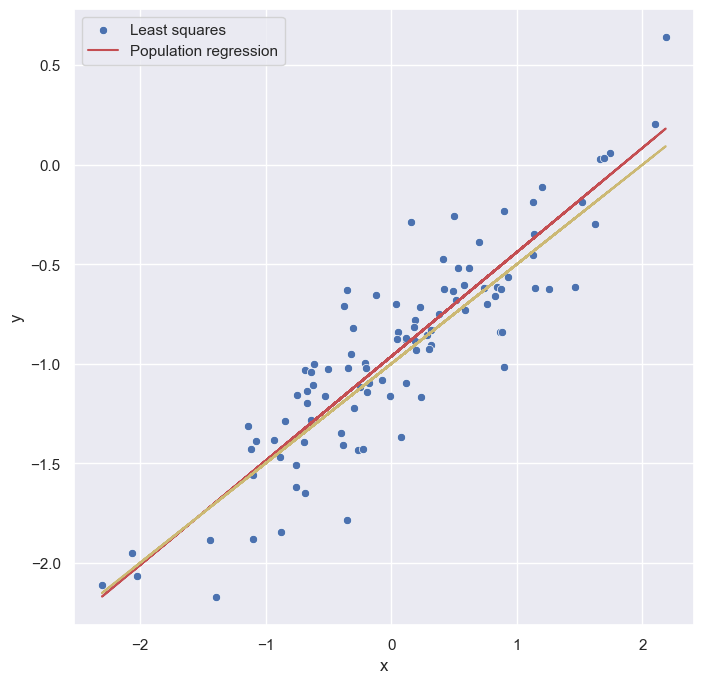

In [123]:
y_pred = model.predict()
y_act  = -1+(0.5*x)

plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares', 'Population regression']);

### (g) Now fit a polynomial regression model that predicts y using x and x2. Is there evidence that the quadratic term improves the model fit? Explain your answer.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     193.8
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           1.32e-34
Time:                        20:55:09   Log-Likelihood:                 4.2077
No. Observations:                 100   AIC:                            -2.415
Df Residuals:                      97   BIC:                             5.400
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9663      0.029    -33.486   

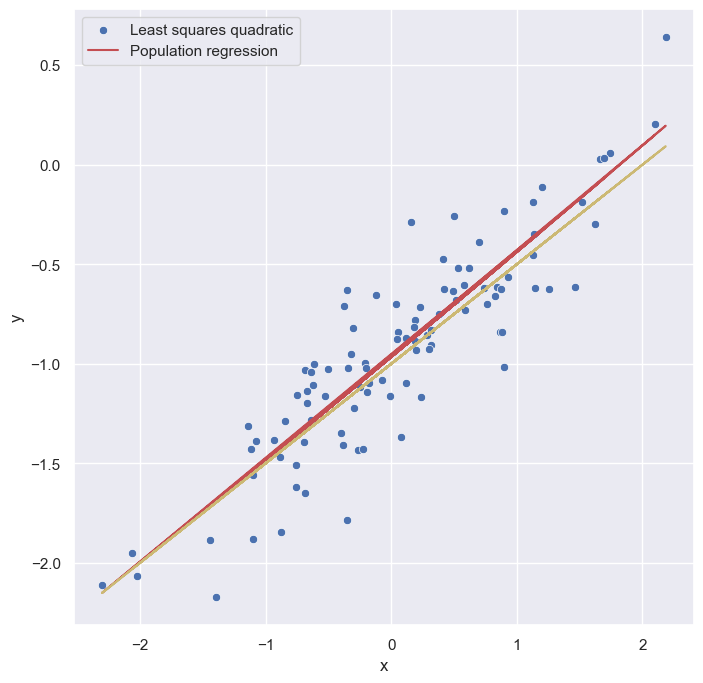

In [124]:
f = 'y ~ x + np.square(x)'
model = smf.ols(formula=f, data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

# predict
y_pred = model.predict()
y_act  = -1+(0.5*x)

# plot
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares quadratic', 'Population regression']);

The model selects a small coefficient for the quadratic variable and so the fit of our model is only slightly affected. The p-value > 0.05 for this variable suggests that it is not statistically significant in representing our data. The R-squared value is identical for both models suggesting that the quadratic model hasn't reduced the error of our model in fitting the data.

Overall the quadratic term does not seem to have improved our model.

### (h) Repeat (a)–(f) after modifying the data generation process in such a way that there is less noise in the data. The model (3.39) should remain the same. You can do this by decreasing the variance of the normal distribution used to generate the error term ε in (b). Describe your results.

y length: 10.617729160380613
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     9084.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           1.97e-98
Time:                        20:55:42   Log-Likelihood:                 165.13
No. Observations:                 100   AIC:                            -326.3
Df Residuals:                      98   BIC:                            -321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9926  

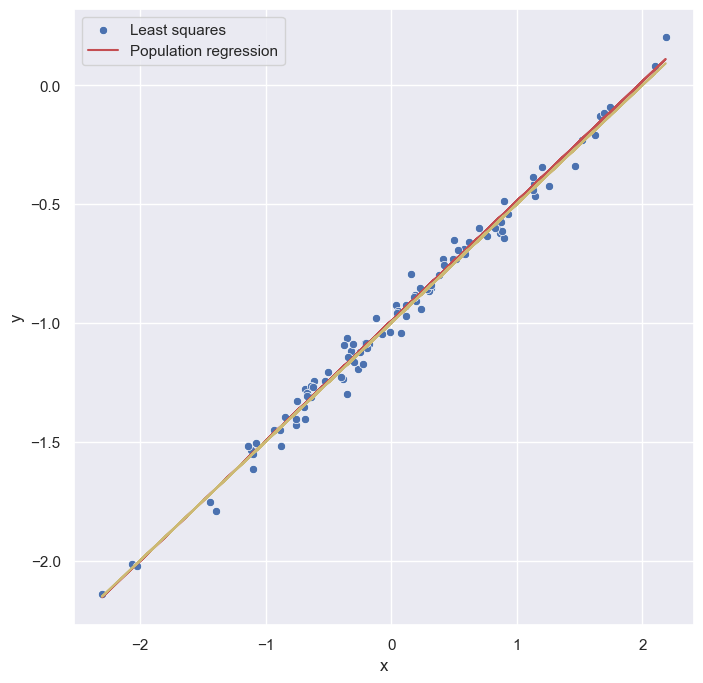

In [125]:
np.random.seed(1)

# generate x
mu, sigma = 0, 1
x = np.random.normal(mu, sigma, 100)

# generate epsilon
mu, sigma = 0, 0.05
eps = np.random.normal(mu, sigma, 100)

# generate y
y = -1 + 0.5*x + eps
print('y length: ' + str(np.linalg.norm(y)))

# Fit model
model = smf.ols(formula='y ~ x', data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

# Make predictions
y_pred = model.predict()
y_act  = -1+(0.5*x)

# Plot results
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares', 'Population regression']);

A dataset with reduced variance results in reduced error in our model. The value of R-squared has increased from 0.8 to 0.989 suggesting a much closer approaximation to the true value of f(x) - this can be seen in reduced dispartiy between the least squares line and the population regression line in th eplot above.

### (i) Repeat (a)–(f) after modifying the data generation process in such a way that there is more noise in the data. The model (3.39) should remain the same. You can do this by increasing the variance of the normal distribution used to generate the error term ε in (b). Describe your results.

y length: 11.173260452749581
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     107.0
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           2.20e-17
Time:                        20:55:50   Log-Likelihood:                -65.124
No. Observations:                 100   AIC:                             134.2
Df Residuals:                      98   BIC:                             139.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9265  

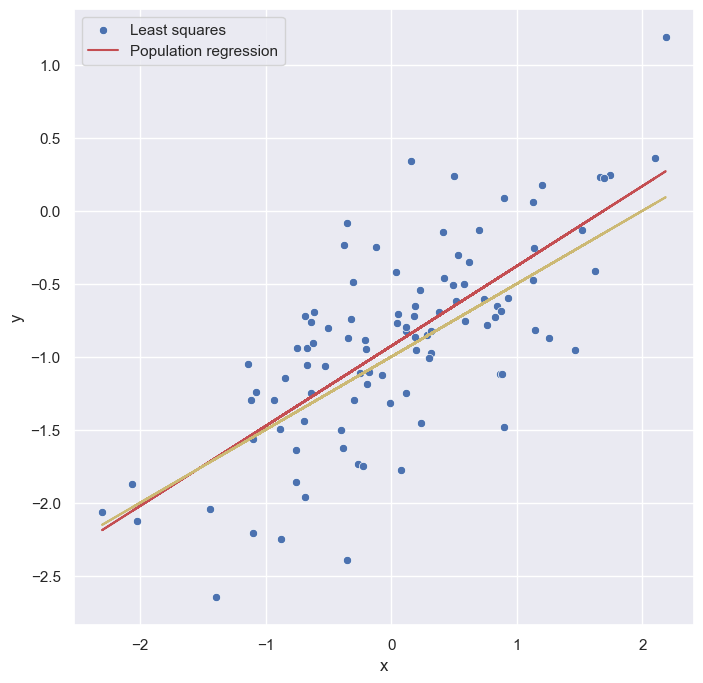

In [126]:
np.random.seed(1)

# generate x
mu, sigma = 0, 1
x = np.random.normal(mu, sigma, 100)

# generate epsilon
mu, sigma = 0, 0.5
eps = np.random.normal(mu, sigma, 100)

# generate y
y = -1 + 0.5*x + eps
print('y length: ' + str(np.linalg.norm(y)))

# Fit model
model = smf.ols(formula='y ~ x', data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

# Make predictions
y_pred = model.predict()
y_act  = -1+(0.5*x)

# Plot results
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares', 'Population regression']);

Increasing the variance in the dataset has increased the error in our model. This is reflected by a reduction in R-squared and an increased disparity between the least squares line and the true population regression line.

### (j) What are the confidence intervals for β0 and β1 based on the original data set, the noisier data set, and the less noisy data set? Comment on your results.

**Less Noisy: Epsilon = 0.05**
```
             [0.025      0.975]
-------------------------------
Intercept    -1.002      -0.983
x             0.494       0.515
```

**Noisier: Epsilon = 0.5**
```
            [0.025      0.975]
------------------------------
Intercept   -1.020      -0.833
x            0.443       0.653

```

Increasing the noise in varaince in our dataset appears to have increased the confidence interval in our model. Increased variance increases uncertainty.

## 14. This problem focuses on the collinearity problem.

#### (a) Perform the following commands in R:

```
set.seed(1)
x1=runif(100)
x2=0.5*x1+rnorm(100)/10
y=2+2*x1+0.3*x2+rnorm(100)
```

The last line corresponds to creating a linear model in which y is a function of x1 and x2. Write out the form of the linear model. What are the regression coefficients?

In [128]:
np.random.seed(1)
x1 = np.random.uniform(size=100)
x2 = 0.5*x1 + np.random.randn(100)/10
y  = 2 + 2*x1 + 0.3*x2 + np.random.randn(100)

Form of the linear model is:

$\hat{y} = β_0 + β_1 x_1 + β_2 x_2 + ɛ$

Where the coefficients are:

$β_0 = 2$  
$β_1 = 2$  
$β_2 = 0.3$  

### (b) What is the correlation between x1 and x2? Create a scatterplot displaying the relationship between the variables.

Correlation coefficient: 0.8390596222844917


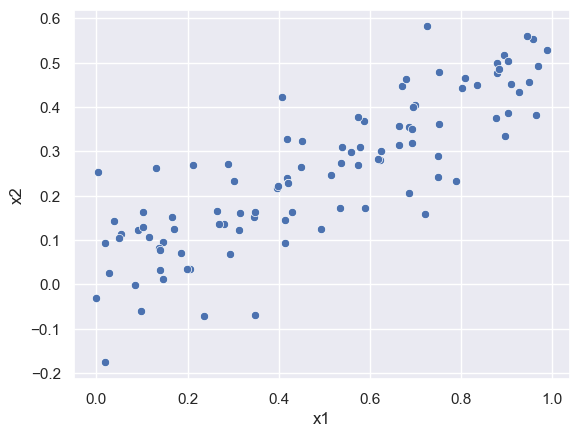

In [129]:
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
sns.scatterplot(x='x1', y='x2', data=df);

print('Correlation coefficient: ' + str(np.corrcoef(x1, x2)[0][1]))

There is correlation between x1 and x2 with coefficient 0.839. The plot suggests a linear relationship with a gradient of around 0.5 and high variance.

### (c) Using this data, fit a least squares regression to predict y using x1 and x2. Describe the results obtained. What are βˆ0, βˆ1, and βˆ2? How do these relate to the true β0, β1, and β2? Can you reject the null hypothesis H0 : β1 = 0? How about the null hypothesis H0 : β2 = 0?

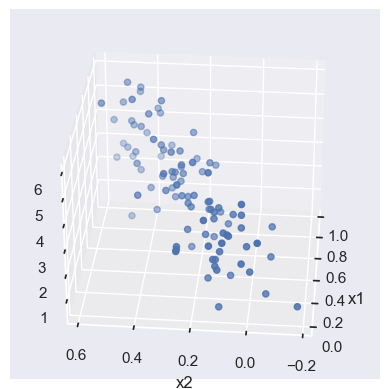

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           4.40e-07
Time:                        20:57:00   Log-Likelihood:                -142.34
No. Observations:                 100   AIC:                             290.7
Df Residuals:                      97   BIC:                             298.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1893      0.199     11.021      0.0

In [130]:
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x1'], df['x2'], df['y'])
ax.view_init(30, 185)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


# Fit model
f = 'y ~ x1 + x2'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())


$β_0 = 2$  
$β_1 = 2$  
$β_2 = 0.3$ 

$\hat{β_0} = 2.1893$  
$\hat{β_1} = 0.7046$  
$\hat{β_2} = 2.5024$ 

- The intercept $\hat{β_0}$ is estimated fairly accurately.
- $\hat{β_1}$ and $\hat{β_2}$ are not well estimated. It's almost as though our model has got these the wrong way around.
- we **cannot** reject the null hypothesis for $\hat{β_1}$
- we **can** reject the null hypothesis for $\hat{β_2}$

### (d) Now fit a least squares regression to predict y using only x1. Comment on your results. Can you reject the null hypothesis H0 :β1 =0?


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.26
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           6.68e-07
Time:                        20:57:30   Log-Likelihood:                -144.76
No. Observations:                 100   AIC:                             293.5
Df Residuals:                      98   BIC:                             298.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2486      0.201     11.209      0.0

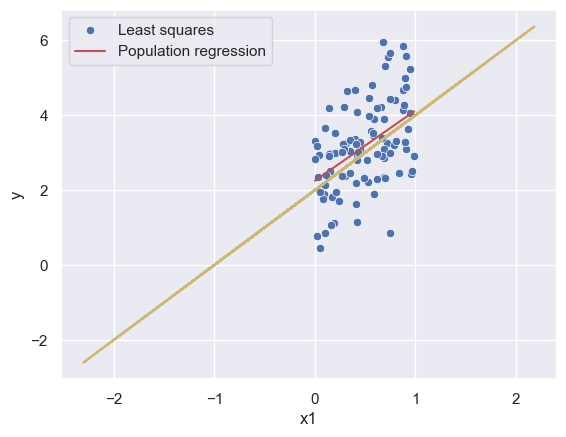

In [131]:
# Fit model
f = 'y ~ x1'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())

df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
ax = sns.scatterplot(x='x1', y='y', data=df);
plt.xlabel('x1')
plt.ylabel('y')
ax.plot(df['x1'].sort_values(), model.predict(df['x1'].sort_values()), color='r')
ax.plot(x, 2+(2*x), color='y')
ax.legend(['Least squares', 'Population regression']);



$β_0 = 2$  
$β_1 = 2$  

$\hat{β_0} = 2.2486$  
$\hat{β_1} = 1.8770$  

- Using only x1 our model makes a much improved prediction of the x1 coefficient $\hat{β_1}$. 
- The p-value now suggests we can reject the null hypothesis H0 :β1 =0 

### (e) Now fit a least squares regression to predict y using only x2. Comment on your results. Can you reject the null hypothesis H0 :β1 =0?

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     32.87
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           1.09e-07
Time:                        20:57:39   Log-Likelihood:                -142.97
No. Observations:                 100   AIC:                             289.9
Df Residuals:                      98   BIC:                             295.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2655      0.187     12.145      0.0

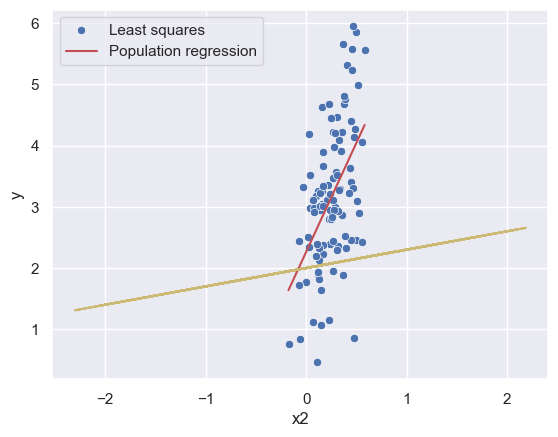

In [132]:
# Fit model
f = 'y ~ x2'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())


df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
ax = sns.scatterplot(x='x2', y='y', data=df);
plt.xlabel('x2')
plt.ylabel('y')
ax.plot(df['x2'].sort_values(), model.predict(df['x2'].sort_values()), color='r')
ax.plot(x, 2+(0.3*x), color='y')
ax.legend(['Least squares', 'Population regression']);


$β_0 = 2$  
$β_2 = 0.3$ 

$\hat{β_0} = 2.2655$  
$\hat{β_2} = 3.5613$ 

Our model overestimates the coefficient. The p-value suggests we can reject the null hypothesis H0 :β2 =0. 

### (f) Do the results obtained in (c)–(e) contradict each other? Explain your answer.

#### Ground truth

$β_0 = 2$  
$β_1 = 2$  
$β_2 = 0.3$ 

#### c) y ~ x1 + x2 
```
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1893      0.199     11.021      0.000       1.795       2.584
x1             0.7046      0.637      1.107      0.271      -0.559       1.968
x2             2.5024      1.140      2.194      0.031       0.239       4.766
```

#### d) y ~ x1
```
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2486      0.201     11.209      0.000       1.850       2.647
x1             1.8770      0.353      5.316      0.000       1.176       2.578
```

#### d) y ~ x2
```
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2655      0.187     12.145      0.000       1.895       2.636
x2             3.5613      0.621      5.733      0.000       2.329       4.794
```

$β_1$
- result c) suggests probability < 0.271 that the null hypothesis $H0 :β_1 =0$ is true
- result d) suggests probability < 0.000 that the null hypothesis $H0 :β_1 =0$ is true

$β_2$
- result c) suggests probability < 0.031 that the null hypothesis $H0 :β_2 =0$ is true
- result e) suggests probability < 0.000 that the null hypothesis $H0 :β_2 =0$ is true

Yes. We get contradictory results for the p-value associated with $β_1$, which in results c woul cause us to accept the null hypothesis and in d) we would reject it.

This contradiction can be explained by the collinearity of x1 and x2 which causes an increased standard error for all $β_j$ when our model incorporates both features, which in turn increases the p-values and causes us to incorrectly accept the null hypothesis $H0 :β_1 =0$ when our model uses both features.

**Revision Notes:** 
- Why is coefficient for x2 estimated at ~4, not 0.3?

### (g) Now suppose we obtain one additional observation, which was unfortunately mismeasured.

```
x1=c(x1, 0.1) 
x2=c(x2, 0.8)
y=c(y,6)
```
Re-fit the linear models from (c) to (e) using this new data. What effect does this new observation have on the each of the models? In each model, is this observation an outlier? A high-leverage point? Both? Explain your answers.


In [133]:
df2 = df.append({'x1': 0.1, 'x2': 0.8, 'y': 6}, ignore_index=True)


# Fit models
model_c = smf.ols(formula='y ~ x1 + x2', data=df2).fit()
model_d = smf.ols(formula='y ~ x1', data=df2).fit()
model_e = smf.ols(formula='y ~ x2', data=df2).fit()

AttributeError: 'DataFrame' object has no attribute 'append'

In [341]:
model_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     19.92
Date:                Wed, 12 Sep 2018   Prob (F-statistic):           5.51e-08
Time:                        18:12:29   Log-Likelihood:                -144.15
No. Observations:                 101   AIC:                             294.3
Df Residuals:                      98   BIC:                             302.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1996      0.199     11.041      0.000       1.804       2.595
x1             0.2200      0.520      0.423      0.673      -0.812       1.252
x2             3.4392      0.892      3.857      0.000       1.670       5.209
==============================================================================
Omnibus:                        1.246   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.536   Jarque-Bera (JB):                1.094
Skew:                          -0.254   Prob(JB):                        0.579
Kurtosis:                       2.956   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [342]:
model_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     21.89
Date:                Wed, 12 Sep 2018   Prob (F-statistic):           9.15e-06
Time:                        18:12:34   Log-Likelihood:                -151.28
No. Observations:                 101   AIC:                             306.6
Df Residuals:                      99   BIC:                             311.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3583      0.208     11.331      0.000       1.945       2.771
x1             1.7225      0.368      4.679      0.000       0.992       2.453
==============================================================================
Omnibus:                        1.904   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.388
Skew:                           0.263   Prob(JB):                        0.500
Kurtosis:                       3.232   Cond. No.                         4.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [343]:
model_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     39.99
Date:                Wed, 12 Sep 2018   Prob (F-statistic):           7.41e-09
Time:                        18:12:48   Log-Likelihood:                -144.24
No. Observations:                 101   AIC:                             292.5
Df Residuals:                      99   BIC:                             297.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2331      0.182     12.271      0.000       1.872       2.594
x2             3.7216      0.589      6.324      0.000       2.554       4.889
==============================================================================
Omnibus:                        1.271   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.094
Skew:                          -0.255   Prob(JB):                        0.579
Kurtosis:                       2.973   Cond. No.                         6.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Comments:** 

- The addition of this anomaly has increased model c's p-value for $\hat{β_1}$, suggesting even more strongly the false acceptance of the null hpyothesis.
- When considered seperately the estimates for $\hat{β_1}$ and $\hat{β_2}$ are worsened by introducing this anomaly.


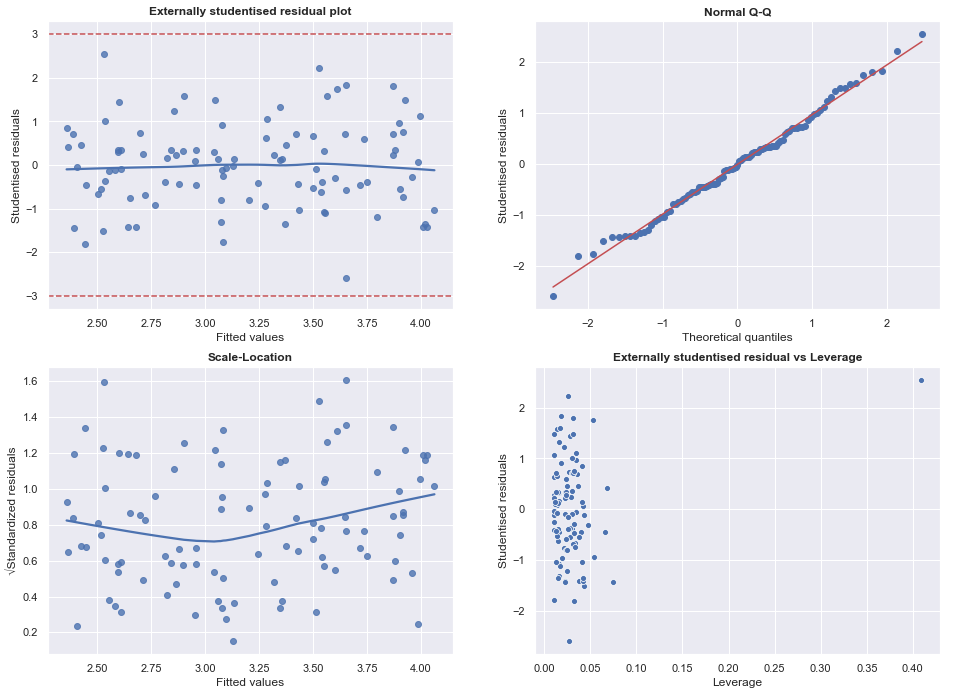

In [359]:
# Model C diagnostics
xc = pd.concat([df2['x1'], df2['x2']], axis=1)
y_pred_c = model_c.predict(xc)
lm_plot(lm_stats(sm.add_constant(xc), df2['y'], y_pred_d))

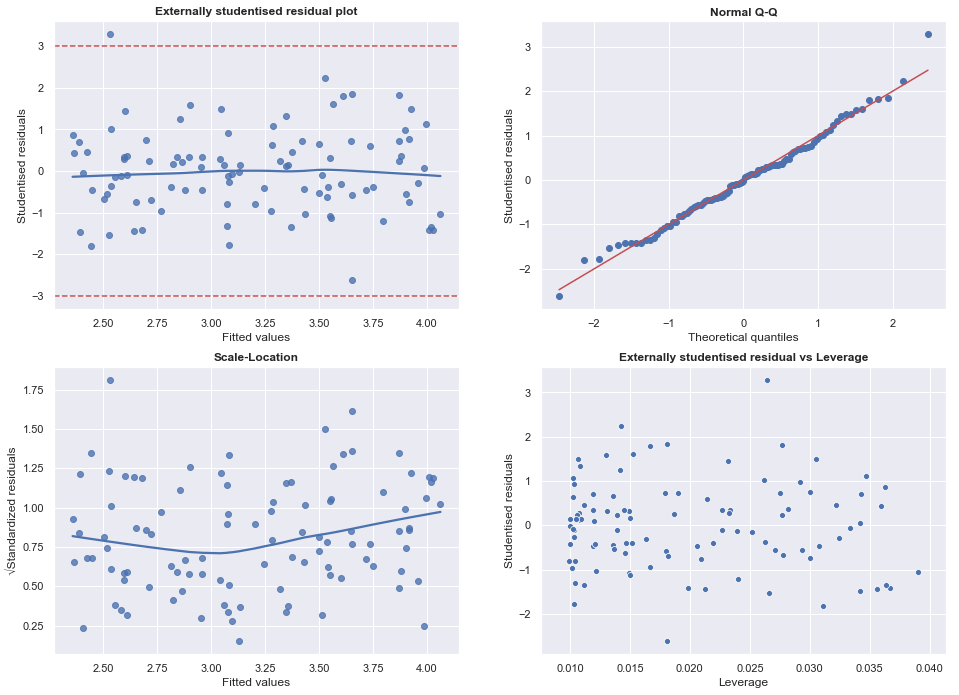

In [357]:
# Model D diagnostics
y_pred_d = model_d.predict(df2['x1'])
lm_plot(lm_stats(sm.add_constant(df2['x1']), df2['y'], y_pred_d))

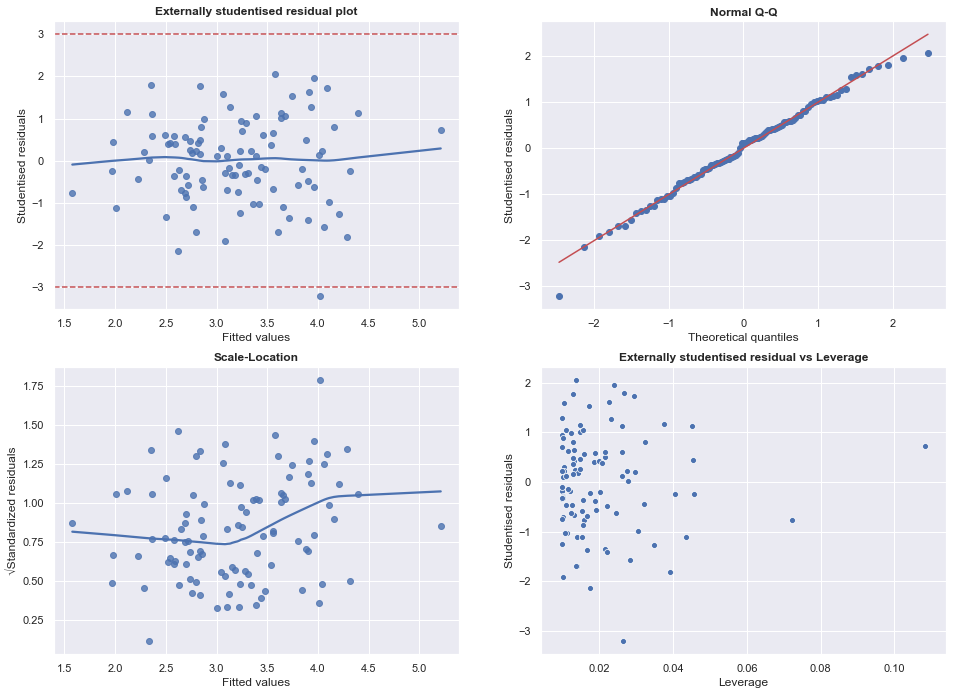

In [358]:
# Model E diagnostics
y_pred_e = model_e.predict(df2['x2'])
lm_plot(lm_stats(sm.add_constant(df2['x2']), df2['y'], y_pred_e))

- model_c : the anomaly is almost an outlier, it is very high leverage
- model_d : the anomaly is an outlier but not particularly high leverage
- model_e : the anomaly is not an outlier but is fairly high leverage

The anomaly has a detrimental effect on model_C, as a high levarage outlier. It has a less detrimental effect on model d and e where it is either low leverage or not an outlier.

This suggests that models with collinear features are less robust in context of anomalous observations.

## 15. This problem involves the Boston data set, which we saw in the lab for this chapter. We will now try to predict per capita crime rate using the other variables in this data set. In other words, per capita crime rate is the response, and the other variables are the predictors.

### (a) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions.

In [505]:
boston = datasets.load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)

# Check for missing values
assert boston_df.isnull().sum().sum() == 0

models_a = [smf.ols(formula='CRIM ~ {}'.format(f), data=boston_df).fit()
            for f in boston_df.columns[1:]]

for model in models_a:
    dp = 4
    display(pd.DataFrame({'coef':    np.around(model.params, dp),
                          'std_err': np.around(model.bse, dp),
                          't':       np.around(model.params / model.bse, dp),
                          'P>|t|':   np.around(model.pvalues, dp),
                          '[0.025':  np.around(model.conf_int(alpha=0.05)[0], dp),
                          '0.975]':  np.around(model.conf_int(alpha=0.05)[1], dp)}))

,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,4.4292,0.4171,10.6198,0.0,3.6098,5.2486
ZN,-0.0735,0.0161,-4.5696,0.0,-0.1051,-0.0419


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.0509,0.6675,-3.0723,0.0022,-3.3624,-0.7394
INDUS,0.5068,0.0510,9.9287,0.0000,0.4066,0.6071


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.7232,0.3959,9.4043,0.0000,2.9454,4.501
CHAS,-1.8715,1.5053,-1.2433,0.2143,-4.8290,1.086


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-13.5881,1.7015,-7.9858,0.0,-16.9310,-10.2451
NOX,30.9753,3.0028,10.3155,0.0,25.0757,36.8748


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,20.506,3.3621,6.0992,0.0,13.9006,27.1114
RM,-2.691,0.5317,-5.0616,0.0,-3.7356,-1.6465


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.7527,0.9442,-3.9745,0.0001,-5.6078,-1.8977
AGE,0.1071,0.0127,8.4094,0.0000,0.0821,0.1322


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,9.4489,0.7306,12.9337,0.0,8.0135,10.8842
DIS,-1.5428,0.1684,-9.1634,0.0,-1.8736,-1.2120


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.2709,0.4448,-5.1053,0.0,-3.1448,-1.3970
RAD,0.6141,0.0344,17.8348,0.0,0.5465,0.6818


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-8.4748,0.8177,-10.3648,0.0,-10.0812,-6.8683
TAX,0.0296,0.0019,15.9661,0.0,0.0259,0.0332


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-17.5307,3.1472,-5.5702,0.0,-23.7139,-11.3474
PTRATIO,1.1446,0.1694,6.7580,0.0,0.8119,1.4774


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,16.2680,1.4300,11.3761,0.0,13.4585,19.0775
B,-0.0355,0.0039,-9.1482,0.0,-0.0432,-0.0279


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.2946,0.6947,-4.7424,0.0,-4.6596,-1.9297
LSTAT,0.5444,0.0478,11.3827,0.0,0.4504,0.6384


In [506]:
# In which of the models is there a statistically significant association between the predictor and the response?

display(HTML('<h3>p < 0.05</h3>'))
for model in models_a:
    if model.pvalues[1] < 0.05:
        print(model.params[1:].index[0])

display(HTML('<h3>p > 0.05</h3>'))
for model in models_a:
    if model.pvalues[1] > 0.05:
        print(model.params[1:].index[0])


ZN
INDUS
NOX
RM
AGE
DIS
RAD
TAX
PTRATIO
B
LSTAT


CHAS


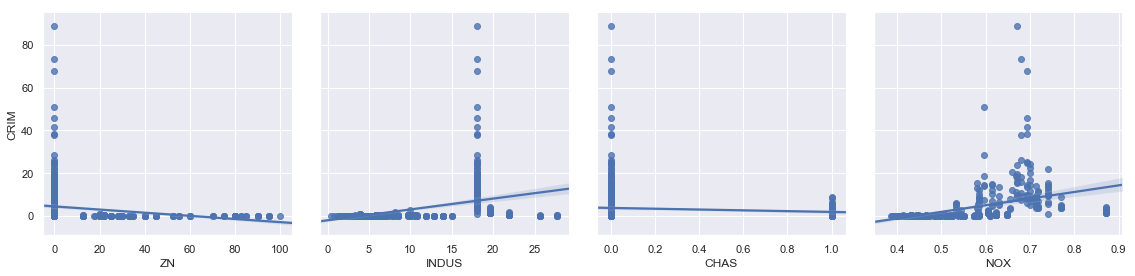

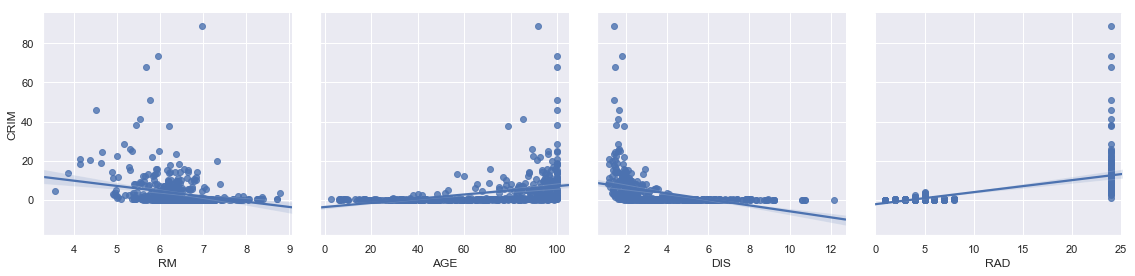

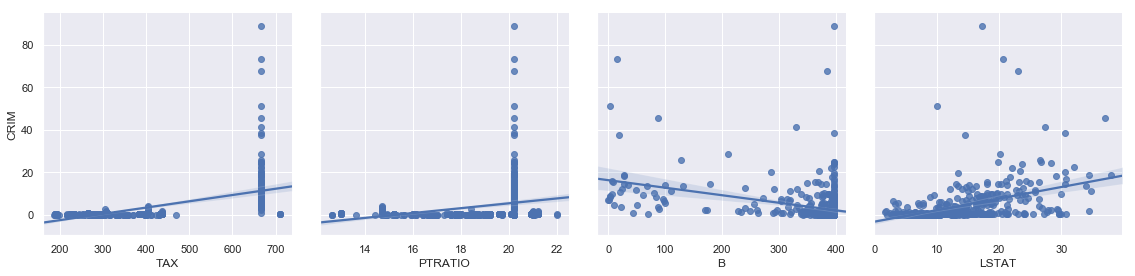

In [490]:
#Create some plots to back up your assertions.
def plot_grid(df, response, cols):
    """ Plot all predictor variables against response in grid """
    variables = df.columns.drop(response)
    for i in range(0, len(variables), cols):
        g = sns.PairGrid(df, y_vars=[response], x_vars=variables[i:i+cols], height=4)
        g.map(sns.regplot);
    return

plot_grid(boston_df, 'CRIM', 4)

### (b) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?

In [504]:
response   = 'CRIM'
predictors = boston_df.columns.drop(response)
f = '{} ~ {}'.format(response, '+'.join(predictors))

model_b = smf.ols(formula=f, data=boston_df).fit()
model_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     31.77
Date:                Thu, 13 Sep 2018   Prob (F-statistic):           6.16e-54
Time:                        11:27:26   Log-Likelihood:                -1661.2
No. Observations:                 506   AIC:                             3348.
Df Residuals:                     493   BIC:                             3403.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3701      7.012      1.479      0.140      -3.408      24.148
ZN             0.0365      0.019      1.936      0.053      -0.001       0.073
INDUS         -0.0672      0.085     -0.794      0.428      -0.233       0.099
CHAS          -1.3049      1.185     -1.101      0.271      -3.633       1.023
NOX           -7.2552      5.250     -1.382      0.168     -17.570       3.060
RM            -0.3851      0.575     -0.670      0.503      -1.515       0.745
AGE            0.0019      0.018      0.105      0.917      -0.034       0.038
DIS           -0.7163      0.273     -2.626      0.009      -1.252      -0.180
RAD            0.5395      0.088      6.128      0.000       0.366       0.712
TAX           -0.0013      0.005     -0.254      0.799      -0.011       0.009
PTRATIO       -0.0907      0.180     -0.504      0.615      -0.445       0.263
B             -0.0089      0.004     -2.428      0.016      -0.016      -0.002
LSTAT          0.2309      0.069      3.346      0.001       0.095       0.366
==============================================================================
Omnibus:                      680.813   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94712.935
Skew:                           6.846   Prob(JB):                         0.00
Kurtosis:                      68.611   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [508]:
# For which predictors can we reject the null hypothesis H0 : βj = 0?¶

display(HTML('<h3>p < 0.05</h3>'))
model_b.pvalues[model_b.pvalues < 0.05]

DIS      8.903325e-03
RAD      1.825980e-09
B        1.554695e-02
LSTAT    8.837421e-04
dtype: float64

### (c) How do your results from (a) compare to your results from (b)? Create a plot displaying the univariate regression coefficients from (a) on the x-axis, and the multiple regression coefficients from (b) on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

Multivariate regression found 4 of 12 predictors to be significnat where univariate regression found 11 of 12 significant. Multivariate regression seems to find significanlty less predictors to be significant.


,Univariate_coef,Multivariate_coef
ZN,-0.073521,0.036455
INDUS,0.506847,-0.067166
CHAS,-1.871545,-1.304904
NOX,30.975259,-7.255168
RM,-2.691045,-0.385127
AGE,0.107131,0.001902
DIS,-1.542831,-0.716287
RAD,0.614137,0.539464
TAX,0.029563,-0.001318
PTRATIO,1.144613,-0.090721


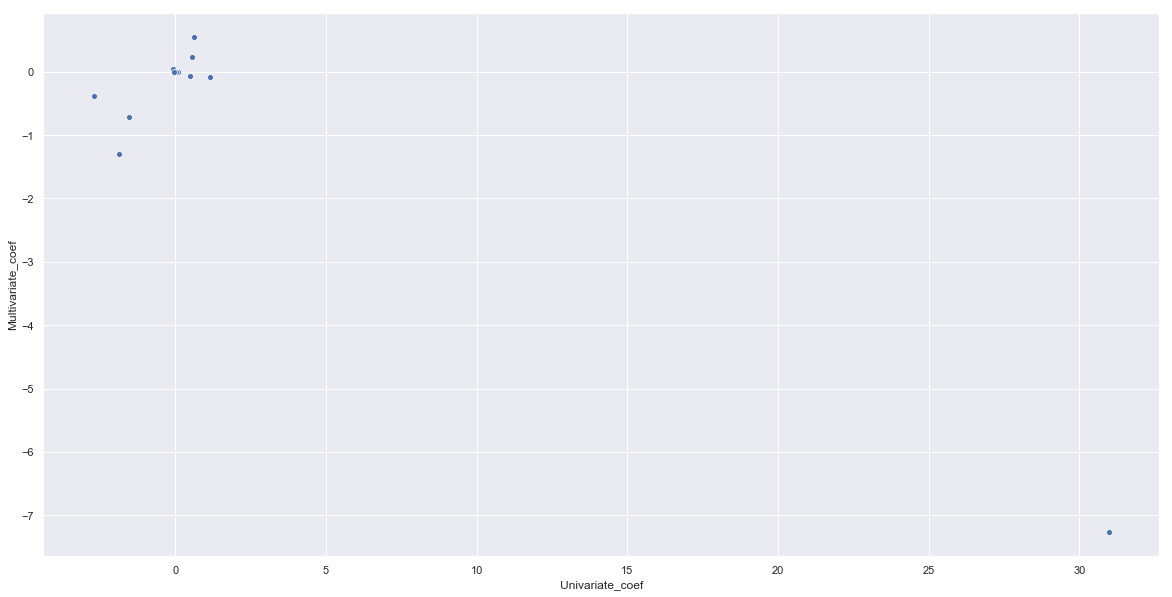

In [531]:
# Get coefficients
univariate_params = pd.concat([m.params[1:] for m in models_a])
multivariate_params = model_b.params[1:]
df = pd.DataFrame({'Univariate_coef': univariate_params, 
                   'Multivariate_coef': multivariate_params,})
display(df)

plt.figure(figsize=(20,10))
ax = sns.scatterplot(x='Univariate_coef', y='Multivariate_coef', data=df);
    

### (d) Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form

$Y = β_0 + β_1 X + β_2 X^2 + β_3 X^3 + ε$

In [542]:
models_d = [smf.ols(formula='CRIM ~ {0} + np.power({0}, 2) + np.power({0}, 3)'.format(f), data=boston_df).fit()
            for f in boston_df.columns[1:]]

for model in models_d:
    dp = 4
    display(pd.DataFrame({'coef':    np.around(model.params, dp),
                          'std_err': np.around(model.bse, dp),
                          't':       np.around(model.params / model.bse, dp),
                          'P>|t|':   np.around(model.pvalues, dp),
                          '[0.025':  np.around(model.conf_int(alpha=0.05)[0], dp),
                          '0.975]':  np.around(model.conf_int(alpha=0.05)[1], dp)}))

,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,4.8193,0.4329,11.1331,0.0000,3.9688,5.6698
ZN,-0.3303,0.1098,-3.0083,0.0028,-0.5459,-0.1146
"np.power(ZN, 2)",0.0064,0.0039,1.6696,0.0956,-0.0011,0.0140
"np.power(ZN, 3)",-0.0000,0.0000,-1.1961,0.2322,-0.0001,0.0000


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.6410,1.5760,2.3103,0.0213,0.5446,6.7374
INDUS,-1.9533,0.4826,-4.0474,0.0001,-2.9015,-1.0051
"np.power(INDUS, 2)",0.2504,0.0394,6.3605,0.0000,0.1731,0.3278
"np.power(INDUS, 3)",-0.0069,0.0010,-7.2392,0.0000,-0.0088,-0.0051


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.7232,0.3959,9.4043,0.0000,2.9454,4.501
CHAS,-0.6238,0.5018,-1.2433,0.2143,-1.6097,0.362
"np.power(CHAS, 2)",-0.6238,0.5018,-1.2433,0.2143,-1.6097,0.362
"np.power(CHAS, 3)",-0.6238,0.5018,-1.2433,0.2143,-1.6097,0.362


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,230.1421,33.7344,6.8222,0.0,163.8641,296.4201
NOX,-1264.1021,170.8598,-7.3985,0.0,-1599.7905,-928.4136
"np.power(NOX, 2)",2223.2265,280.6587,7.9215,0.0,1671.8160,2774.6370
"np.power(NOX, 3)",-1232.3894,149.6867,-8.2331,0.0,-1526.4790,-938.2999


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,111.9002,64.4600,1.7360,0.0832,-14.7444,238.5447
RM,-38.7040,31.2837,-1.2372,0.2166,-100.1671,22.7591
"np.power(RM, 2)",4.4655,5.0054,0.8921,0.3727,-5.3686,14.2997
"np.power(RM, 3)",-0.1694,0.2635,-0.6428,0.5207,-0.6871,0.3483


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.5592,2.7706,-0.9237,0.3561,-8.0027,2.8843
AGE,0.2743,0.1865,1.4707,0.1420,-0.0921,0.6406
"np.power(AGE, 2)",-0.0072,0.0036,-1.9874,0.0474,-0.0144,-0.0001
"np.power(AGE, 3)",0.0001,0.0000,2.7185,0.0068,0.0000,0.0001


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,29.9496,2.4479,12.2350,0.0,25.1403,34.7589
DIS,-15.5172,1.7374,-8.9314,0.0,-18.9306,-12.1038
"np.power(DIS, 2)",2.4479,0.3467,7.0605,0.0,1.7667,3.1291
"np.power(DIS, 3)",-0.1185,0.0204,-5.8020,0.0,-0.1586,-0.0783


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-0.6050,2.0565,-0.2942,0.7687,-4.6455,3.4355
RAD,0.5122,1.0469,0.4893,0.6249,-1.5446,2.5690
"np.power(RAD, 2)",-0.0750,0.1490,-0.5036,0.6148,-0.3678,0.2177
"np.power(RAD, 3)",0.0032,0.0046,0.6986,0.4851,-0.0058,0.0122


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,19.0705,11.8271,1.6124,0.1075,-4.1662,42.3072
TAX,-0.1524,0.0959,-1.5889,0.1127,-0.3409,0.0360
"np.power(TAX, 2)",0.0004,0.0002,1.4756,0.1407,-0.0001,0.0008
"np.power(TAX, 3)",-0.0000,0.0000,-1.1578,0.2475,-0.0000,0.0000


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,474.0255,156.8229,3.0227,0.0026,165.9154,782.1355
PTRATIO,-81.8089,27.6489,-2.9589,0.0032,-136.1306,-27.4872
"np.power(PTRATIO, 2)",4.6039,1.6086,2.8621,0.0044,1.4435,7.7644
"np.power(PTRATIO, 3)",-0.0842,0.0309,-2.7240,0.0067,-0.1449,-0.0235


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,17.9898,2.3116,7.7825,0.0000,13.4483,22.5314
B,-0.0845,0.0565,-1.4966,0.1351,-0.1955,0.0264
"np.power(B, 2)",0.0002,0.0003,0.7602,0.4475,-0.0004,0.0008
"np.power(B, 3)",-0.0000,0.0000,-0.6614,0.5087,-0.0000,0.0000


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,1.0836,2.0321,0.5333,0.5941,-2.9088,5.0761
LSTAT,-0.4133,0.4657,-0.8874,0.3753,-1.3282,0.5017
"np.power(LSTAT, 2)",0.0530,0.0302,1.7584,0.0793,-0.0062,0.1123
"np.power(LSTAT, 3)",-0.0008,0.0006,-1.4231,0.1553,-0.0019,0.0003


In [561]:
# In which of the models is there a statistically significant association between the predictor and the response?

display(HTML('<h3>Features with p < 0.05</h3>'))

sig = pd.concat([model.pvalues[model.pvalues < 0.05] for model in models_d])

display(pd.DataFrame({'P>|t|':sig.drop('Intercept')}))


,P>|t|
ZN,2.759026e-03
INDUS,5.996850e-05
"np.power(INDUS, 2)",4.530067e-10
"np.power(INDUS, 3)",1.704441e-12
NOX,5.832574e-13
"np.power(NOX, 2)",1.522887e-14
"np.power(NOX, 3)",1.587778e-15
"np.power(AGE, 2)",4.742487e-02
"np.power(AGE, 3)",6.784650e-03
DIS,7.973990e-18


- There is evidence of a non-linear association between the repsonse and INDUS, NOX, AGE, DIS, PTRATIO
- There is evidence of a linear association between the response and ZN